In [36]:
#unfortunately we were not able to share the code using the git commands as planned, due to repeated errors when trying to access GitHub and general problem with the repository. We are very sorry for this inconvenience.
#In any case, we are sharing the link to the repository here: [https://github.com/saramariasecreti/fds-pokemon-Log-karp-Crew.git]. However, since we are required to submit the full work, we are also attaching the complete notebook as a last resort to make sure you can access all the code and results.


In [6]:
# IMPORT
#Import all necessary libraries for data processing, machine learning, and visualization.
#We define basic constants like target variable and random seed.
import numpy as np
import pandas as pd
import os
import json
from pathlib import Path
from math import log
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
from itertools import product
from sklearn.model_selection import learning_curve
warnings.filterwarnings('ignore')

COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
COL_ID = "battle_id"
DATA_PATH = os.path.join('/kaggle/input', COMPETITION_NAME)
COL_TARGET = "player_won"
SEED = 1234

In [7]:
# DEFINE THE PATH TO THE DATA ON KAGGLE

train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')
train_data = []

print(f"Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            train_data.append(json.loads(line))

    print(f"Successfully loaded {len(train_data)} battles.")

    print("\n--- Structure of the first train battle: ---")
    if train_data:
        first_battle = train_data[0]

        battle_for_display = first_battle.copy()
        battle_for_display['battle_timeline'] = battle_for_display.get('battle_timeline', [])[:2]

        print(json.dumps(battle_for_display, indent=4))
        if len(first_battle.get('battle_timeline', [])) > 3:
            print("    ...")
            print("    (battle_timeline has been truncated for display)")

except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{train_file_path}'.")
    print("Check that the competition data is correctly attached to this notebook.")


Loading data from '/kaggle/input/fds-pokemon-battles-prediction-2025/train.jsonl'...
Successfully loaded 10000 battles.

--- Structure of the first train battle: ---
{
    "player_won": true,
    "p1_team_details": [
        {
            "name": "starmie",
            "level": 100,
            "types": [
                "psychic",
                "water"
            ],
            "base_hp": 60,
            "base_atk": 75,
            "base_def": 85,
            "base_spa": 100,
            "base_spd": 100,
            "base_spe": 115
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 95,
            "base_atk": 95,
            "base_def": 85,
            "base_spa": 125,
            "base_spd": 125,
            "base_spe": 55
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
                "nor

In [8]:
def load_data():
    train_df = pd.read_json(os.path.join(DATA_PATH, "train.jsonl"), lines=True)
    test_df  = pd.read_json(os.path.join(DATA_PATH, "test.jsonl"),  lines=True)

    print(f" Train: {train_df.shape[0]} battles")
    print(f" Test:  {test_df.shape[0]} battles")

    assert COL_TARGET in train_df.columns, "Target missing!"
    assert COL_TARGET not in test_df.columns, "Target leakage!"

    return train_df, test_df

train_df, test_df = load_data()


 Train: 10000 battles
 Test:  5000 battles


In [9]:
# DATA CLEANING


print("\nCleaning data...")

# Remove flawed row (index 4877 or battle_id 4877)
flawed_indices = []

# Check by index
if len(train_df) > 4877:
    flawed_indices.append(4877)

# Check by battle_id
if COL_ID in train_df.columns:
    flawed_by_id = train_df[train_df[COL_ID] == 4877].index.tolist()
    flawed_indices.extend(flawed_by_id)

# Remove duplicates and drop
flawed_indices = list(set(flawed_indices))
if flawed_indices:
    train_df = train_df.drop(index=flawed_indices).reset_index(drop=True)
    print(f" Removed {len(flawed_indices)} flawed row(s): {flawed_indices}")
    print(f" Train shape after cleaning: {train_df.shape}")
else:
    print(" No flawed rows found")


Cleaning data...
 Removed 1 flawed row(s): [4877]
 Train shape after cleaning: (9999, 5)


In [10]:
# HELPER FUNCTIONS & CONSTANTS
# We define domain-specific constants based on competitive Gen 1 Pokemon knowledge. High-value targets are Pokemon that become
# especially vulnerable when afflicted with specific status conditions - for example, fast sweepers like Tauros suffer most from
# paralysis. We set temporal thresholds to distinguish early game (turns 1-5), mid game, and late game (turn 20+), and define
# severity weights for different status conditions where sleep is most impactful at 3.0 and burn least at 1.2.

HIGHVALUE_SLEEP_TARGETS = {"tauros", "snorlax", "starmie", "alakazam", "jynx"}
HIGHVALUE_PARALYZE_TARGETS = {"tauros", "alakazam", "starmie", "zapdos", "jolteon"}
SPECIAL_WALLS_FOR_FREEZE = {"chansey", "starmie"}
PHYSICAL_TITANS_FOR_BURN = {"tauros", "snorlax", "rhydon", "golem"}

STATUS_CODES = {"slp", "par", "frz", "brn"}
EARLY_TURN_THRESHOLD = 5
LATE_TURN_THRESHOLD = 20

STATUS_SEVERITY = {"slp": 3.0, "frz": 2.5, "par": 1.5, "brn": 1.2}
TEMPORAL_DECAY = 0.95
LATE_GAME_CONTROL_THRESHOLD = 2

EFFECT_WEIGHTS = {'reflect': 2.0, 'substitute': 1.5, 'leech seed': 1.0, 'light screen': 0.5}

print('Helper defined')

Helper defined


In [11]:
# ROLE TAXONOMY 
# We classify Pokemon into five competitive roles based on Gen 1 OU metagame: physical/special walls for defense, physical/special
# breakers for offense, and status spreaders for support. Helper functions identify Pokemon roles dynamically by checking both
# their species and moves used during battle. We also define move categories (setup, wall, status moves) to refine role detection
# since Pokemon can fulfill multiple roles depending on their moveset in a specific battle.

ROLE_TAXONOMY = {
    'wall_phys': {'cloyster', 'golem', 'rhydon', 'articuno'},
    'wall_spec': {'chansey', 'snorlax'},
    'breaker_phys': {'tauros', 'snorlax'},
    'breaker_spec': {'alakazam', 'starmie', 'jolteon', 'zapdos', 'jynx', 'exeggutor'},
    'status_spreader': {'jynx', 'exeggutor', 'chansey', 'starmie', 'zapdos', 'gengar'}
}

SETUP_MOVES = {'amnesia', 'swordsdance'}
WALL_MOVES = {'reflect', 'rest', 'recover'}
STATUS_MOVES = {'thunderwave', 'sleeppowder', 'lovelykiss', 'hypnosis', 'stunspore'}


def _collect_status_events(row) -> list:
    "Extract status events with timing and details"
    timeline = row.get("battle_timeline", []) or []
    events = [
        {"turn": int(t.get("turn", 0)), "side": side, 
         "target": ((t.get(f"{side}_pokemon_state", {}) or {}).get("name") or "").lower(),
         "status": (t.get(f"{side}_pokemon_state", {}) or {}).get("status", "nostatus")}
        for t in timeline
        for side in ("p1", "p2")
        if (t.get(f"{side}_pokemon_state", {}) or {}).get("status", "nostatus") in STATUS_CODES
    ]
    return sorted(events, key=lambda e: e["turn"])


def _is_highvalue_target(pokemon_name: str) -> bool:
    "Check if pokemon is high-value for any status"
    return pokemon_name in (HIGHVALUE_SLEEP_TARGETS | HIGHVALUE_PARALYZE_TARGETS | 
                           SPECIAL_WALLS_FOR_FREEZE | PHYSICAL_TITANS_FOR_BURN)


def _get_pokemon_roles(pokemon_name: str, moves_used: set = None) -> set:
    "Determine pokemon roles based on taxonomy and moves used."
    pokemon_name = pokemon_name.lower()
    roles = {role for role, pokemon_set in ROLE_TAXONOMY.items() if pokemon_name in pokemon_set}
    
    if moves_used:
        moves_lower = {m.lower() for m in moves_used}
        if moves_lower & SETUP_MOVES:
            roles.add('bulky_setup')
        if moves_lower & WALL_MOVES:
            roles.add('wall_spec' if pokemon_name in {'snorlax', 'chansey'} else 'wall_phys')
        if moves_lower & STATUS_MOVES:
            roles.add('status_spreader')
    
    return roles

print('Role taxonomy defined')

Role taxonomy defined


In [12]:
# ROLE-BASED ENDGAME FEATURES
# We extract the role composition of surviving Pokemon at turn 30 to measure endgame team balance. The function tracks all Pokemon
# throughout the battle, identifies which ones fainted, and counts how many of each role survived. This creates 15 features
# (5 roles × 3 metrics: p1 count, p2 count, difference) that capture strategic position - for example, having more special breakers
# alive often indicates offensive advantage while more walls suggest defensive resilience.

def _extract_survivor_roles(row):
    
    'Extract role counts for surviving pokemon at turn 30.'
    'Returns dict with role counts for p1 and p2.'
    
    timeline = row.get("battle_timeline", []) or []
    if not timeline:
        return {role: (0, 0) for role in ROLE_TAXONOMY.keys()}
    
    # Find turn 30 or last turn
    turns = [int(t.get("turn", 0)) for t in timeline]
    if not turns:
        return {role: (0, 0) for role in ROLE_TAXONOMY.keys()}
    
    target_turn = min(30, max(turns))
    
    # Track fainted pokemon throughout battle
    p1_fainted = set()
    p2_fainted = set()
    
    # Track moves used by each pokemon
    p1_moves = {}  # pokemon_name -> set of moves
    p2_moves = {}
    
    for t in timeline:
        turn = int(t.get("turn", 0))
        if turn > target_turn:
            break
        
        # Track fainted
        p1_state = t.get("p1_pokemon_state", {}) or {}
        p2_state = t.get("p2_pokemon_state", {}) or {}
        
        p1_name = (p1_state.get("name") or "").lower()
        p2_name = (p2_state.get("name") or "").lower()
        
        if p1_state.get("hp_pct", 1.0) == 0 and p1_name:
            p1_fainted.add(p1_name)
        if p2_state.get("hp_pct", 1.0) == 0 and p2_name:
            p2_fainted.add(p2_name)
        
        # Track moves
        p1_move = t.get("p1_move_details", {}) or {}
        p2_move = t.get("p2_move_details", {}) or {}
        
        if p1_name:
            if p1_name not in p1_moves:
                p1_moves[p1_name] = set()
            move_name = (p1_move.get("name") or "").lower()
            if move_name:
                p1_moves[p1_name].add(move_name)
        
        if p2_name:
            if p2_name not in p2_moves:
                p2_moves[p2_name] = set()
            move_name = (p2_move.get("name") or "").lower()
            if move_name:
                p2_moves[p2_name].add(move_name)
    
    # Get all unique pokemon names from timeline
    p1_team = set()
    p2_team = set()
    
    for t in timeline[:target_turn]:
        p1_state = t.get("p1_pokemon_state", {}) or {}
        p2_state = t.get("p2_pokemon_state", {}) or {}
        
        p1_name = (p1_state.get("name") or "").lower()
        p2_name = (p2_state.get("name") or "").lower()
        
        if p1_name:
            p1_team.add(p1_name)
        if p2_name:
            p2_team.add(p2_name)
    
    # Calculate survivors
    p1_survivors = p1_team - p1_fainted
    p2_survivors = p2_team - p2_fainted
    
    # Count roles among survivors
    role_counts = {}
    
    for role in ROLE_TAXONOMY.keys():
        p1_count = 0
        p2_count = 0
        
        for pokemon in p1_survivors:
            moves_used = p1_moves.get(pokemon, set())
            roles = _get_pokemon_roles(pokemon, moves_used)
            if role in roles:
                p1_count += 1
        
        for pokemon in p2_survivors:
            moves_used = p2_moves.get(pokemon, set())
            roles = _get_pokemon_roles(pokemon, moves_used)
            if role in roles:
                p2_count += 1
        
        role_counts[role] = (p1_count, p2_count)
    
    return role_counts

def _make_role_features(row):
    "Create role-based endgame features"
    role_counts = _extract_survivor_roles(row)
    
    features = {}
    
    for role, (p1_count, p2_count) in role_counts.items():
        features[f'p1_rolecount_{role}_end'] = p1_count
        features[f'p2_rolecount_{role}_end'] = p2_count
        features[f'rolecount_{role}_diff_end'] = p1_count - p2_count
    
    return pd.Series(features, dtype="float64")
print('Role defined')

Role defined


In [13]:
# HP DISTRIBUTION & DISPERSION FEATURES
# We calculate comprehensive HP statistics for alive Pokemon at turn 30 to assess team health quality. Beyond simple averages, we compute
# standard deviation and coefficient of variation to measure HP dispersion - low dispersion means damage is concentrated on few Pokemon while
# high dispersion indicates spread damage. We also create weighted averages using Pokemon tier values and effective HP adjusted for status
# penalties. These 12 features capture not just how much HP remains but how evenly distributed and how impactful that HP is.

POKEMON_VALUES = {
    'tauros': 1.5,
    'chansey': 1.2,
    'zapdos': 1.0,
    'exeggutor': 1.0,
    'alakazam': 1.0,
    'slowbro': 1.0,
    'starmie': 0.9,
    'snorlax': 1.2,
    'jynx': 0.8,
    'lapras': 0.8,
}
def _calculate_hp_distribution_features(row):
    "Extract HP distribution statistics for alive pokemon at T30."
    timeline = row.get("battle_timeline", []) or []
    default_result = {
        'p1_avg_hp': 0, 'p2_avg_hp': 0, 'p1_std_hp': 0, 'p2_std_hp': 0,
        'p1_cv_hp': 0, 'p2_cv_hp': 0, 'p1_median_hp': 0, 'p2_median_hp': 0,
        'p1_high_dispersion': 0, 'p2_high_dispersion': 0,
        'p1_weighted_avg_hp': 0, 'p2_weighted_avg_hp': 0,
        'p1_effective_avg_hp': 0, 'p2_effective_avg_hp': 0
    }
    
    if not timeline:
        return default_result
    
    turns = [int(t.get("turn", 0)) for t in timeline]
    if not turns:
        return default_result
    
    target_turn = min(30, max(turns))
    
    # Track all pokemon throughout battle
    p1_pokemon_hp, p2_pokemon_hp = {}, {}
    p1_pokemon_status, p2_pokemon_status = {}, {}
    p1_fainted, p2_fainted = set(), set()
    
    for t in timeline:
        if int(t.get("turn", 0)) > target_turn:
            break
        
        for side, hp_dict, status_dict, fainted_set in [
            ("p1", p1_pokemon_hp, p1_pokemon_status, p1_fainted),
            ("p2", p2_pokemon_hp, p2_pokemon_status, p2_fainted)
        ]:
            state = t.get(f"{side}_pokemon_state", {}) or {}
            name = (state.get("name") or "").lower()
            if name:
                hp_pct = state.get("hp_pct", 0.0)
                hp_dict[name] = hp_pct
                status_dict[name] = state.get("status", "nostatus")
                if hp_pct == 0:
                    fainted_set.add(name)
    
    # Get alive pokemon HP values
    p1_alive_hp = [hp for name, hp in p1_pokemon_hp.items() if name not in p1_fainted and hp > 0]
    p2_alive_hp = [hp for name, hp in p2_pokemon_hp.items() if name not in p2_fainted and hp > 0]
    
    # Helper function to calculate statistics for one side
    def calc_stats(alive_hp, pokemon_hp, pokemon_status, fainted):
        if not alive_hp:
            return 0, 0, 0, 0, 0, 0, 0
        
        avg = np.mean(alive_hp)
        median = np.median(alive_hp)
        std = min(np.std(alive_hp), 0.5) if len(alive_hp) > 1 else 0.0
        cv = (std / avg) if avg > 0 else 0.0
        high_disp = 1 if std > 0.25 else 0
        
        # Weighted average
        weighted_hp = [hp * POKEMON_VALUES.get(name, 0.6) 
                      for name, hp in pokemon_hp.items() if name not in fainted and hp > 0]
        weighted_avg = np.mean(weighted_hp) if weighted_hp else 0.0
        
        # Effective HP (penalized by status)
        status_penalty = {'slp': 0.8, 'frz': 0.6, 'par': 0.75, 'brn': 0.6}
        effective_hp = [hp * status_penalty.get(pokemon_status.get(name, "nostatus"), 1.0)
                       for name, hp in pokemon_hp.items() if name not in fainted and hp > 0]
        effective_avg = np.mean(effective_hp) if effective_hp else 0.0
        
        return avg, median, std, cv, high_disp, weighted_avg, effective_avg
    
    p1_avg, p1_median, p1_std, p1_cv, p1_high_disp, p1_weighted_avg, p1_effective_avg = \
        calc_stats(p1_alive_hp, p1_pokemon_hp, p1_pokemon_status, p1_fainted)
    
    p2_avg, p2_median, p2_std, p2_cv, p2_high_disp, p2_weighted_avg, p2_effective_avg = \
        calc_stats(p2_alive_hp, p2_pokemon_hp, p2_pokemon_status, p2_fainted)
    
    return {
        'p1_avg_hp': p1_avg, 'p2_avg_hp': p2_avg,
        'p1_std_hp': p1_std, 'p2_std_hp': p2_std,
        'p1_cv_hp': p1_cv, 'p2_cv_hp': p2_cv,
        'p1_median_hp': p1_median, 'p2_median_hp': p2_median,
        'p1_high_dispersion': p1_high_disp, 'p2_high_dispersion': p2_high_disp,
        'p1_weighted_avg_hp': p1_weighted_avg, 'p2_weighted_avg_hp': p2_weighted_avg,
        'p1_effective_avg_hp': p1_effective_avg, 'p2_effective_avg_hp': p2_effective_avg
    }


def _make_hp_distribution_features(row):
    "Create HP distribution features with diffs and interactions"
    stats = _calculate_hp_distribution_features(row)
    
    # Calculate alive count for interactions
    timeline = row.get("battle_timeline", []) or []
    p1_alive = p2_alive = 0
    
    if timeline:
        turns = [int(t.get("turn", 0)) for t in timeline]
        if turns:
            target_turn = min(30, max(turns))
            p1_fainted, p2_fainted = set(), set()
            p1_team, p2_team = set(), set()
            
            for t in timeline:
                turn = int(t.get("turn", 0))
                if turn > target_turn:
                    break
                
                for side, fainted_set, team_set in [("p1", p1_fainted, p1_team), 
                                                     ("p2", p2_fainted, p2_team)]:
                    state = t.get(f"{side}_pokemon_state", {}) or {}
                    name = (state.get("name") or "").lower()
                    if name:
                        team_set.add(name)
                        if state.get("hp_pct", 0) == 0:
                            fainted_set.add(name)
            
            p1_alive = len(p1_team - p1_fainted)
            p2_alive = len(p2_team - p2_fainted)
    
    alive_count_diff = p1_alive - p2_alive
    
    # Calculate diffs
    diffs = {
        'avg_hp_alive_diff': np.clip(stats['p1_avg_hp'] - stats['p2_avg_hp'], -1.0, 1.0),
        'std_hp_alive_diff': np.clip(stats['p1_std_hp'] - stats['p2_std_hp'], -0.5, 0.5),
        'cv_hp_alive_diff': stats['p1_cv_hp'] - stats['p2_cv_hp'],
        'median_hp_alive_diff': stats['p1_median_hp'] - stats['p2_median_hp'],
        'dispersion_flag_diff': stats['p1_high_dispersion'] - stats['p2_high_dispersion'],
        'weighted_avg_hp_diff': np.clip(stats['p1_weighted_avg_hp'] - stats['p2_weighted_avg_hp'], -1.0, 1.0),
        'effective_avg_hp_diff': np.clip(stats['p1_effective_avg_hp'] - stats['p2_effective_avg_hp'], -1.0, 1.0),
    }
    
    return pd.Series({
        'p1_avg_hp_alive': stats['p1_avg_hp'],
        'p2_avg_hp_alive': stats['p2_avg_hp'],
        'p1_std_hp_alive': stats['p1_std_hp'],
        'p2_std_hp_alive': stats['p2_std_hp'],
        **diffs,
        'std_hp_x_alive_diff': diffs['std_hp_alive_diff'] * alive_count_diff,
    }, dtype="float64")

print('Help features defined')

Help features defined


In [14]:
# STATUS STATE AT T30 FEATURES
# We count Pokemon afflicted with status conditions among survivors at turn 30, specifically tracking sleep, freeze, and paralysis
# as these severely reduce combat effectiveness. A team with multiple statused Pokemon at endgame faces significant handicap even
# if they have HP advantage. We create 12 features measuring status burden for each side and their differences, which helps predict
# outcomes in close battles where material advantage alone isn't decisive.

def _extract_status_at_t30(row):
    "Extract status conditions of survivors at turn 30."
    timeline = row.get("battle_timeline", []) or []
    default = {'p1_statused_alive': 0, 'p2_statused_alive': 0, 'p1_sleepers': 0, 
               'p2_sleepers': 0, 'p1_freezes': 0, 'p2_freezes': 0, 'p1_paras': 0, 'p2_paras': 0}
    
    if not timeline:
        return default
    
    turns = [int(t.get("turn", 0)) for t in timeline]
    if not turns:
        return default
    
    target_turn = min(30, max(turns))
    
    # Track pokemon status throughout battle
    p1_pokemon_status, p2_pokemon_status = {}, {}
    p1_fainted, p2_fainted = set(), set()
    
    for t in timeline:
        if int(t.get("turn", 0)) > target_turn:
            break
        
        for side, status_dict, fainted_set in [("p1", p1_pokemon_status, p1_fainted),
                                                ("p2", p2_pokemon_status, p2_fainted)]:
            state = t.get(f"{side}_pokemon_state", {}) or {}
            name = (state.get("name") or "").lower()
            if name:
                status_dict[name] = state.get("status", "nostatus")
                if state.get("hp_pct", 1.0) == 0:
                    fainted_set.add(name)
    
    # Count status among survivors
    def count_status(pokemon_status, fainted):
        statused = sleepers = freezes = paras = 0
        for pokemon, status in pokemon_status.items():
            if pokemon not in fainted and status in STATUS_CODES:
                statused += 1
                if status == 'slp':
                    sleepers += 1
                elif status == 'frz':
                    freezes += 1
                elif status == 'par':
                    paras += 1
        return statused, sleepers, freezes, paras
    
    p1_statused, p1_sleepers, p1_freezes, p1_paras = count_status(p1_pokemon_status, p1_fainted)
    p2_statused, p2_sleepers, p2_freezes, p2_paras = count_status(p2_pokemon_status, p2_fainted)
    
    return {
        'p1_statused_alive': p1_statused, 'p2_statused_alive': p2_statused,
        'p1_sleepers': p1_sleepers, 'p2_sleepers': p2_sleepers,
        'p1_freezes': p1_freezes, 'p2_freezes': p2_freezes,
        'p1_paras': p1_paras, 'p2_paras': p2_paras
    }


def _make_status_t30_features(row):
    "Create status-at-T30 features"
    sc = _extract_status_at_t30(row)
    
    return pd.Series({
        'p1_statused_alive_end': sc['p1_statused_alive'],
        'p2_statused_alive_end': sc['p2_statused_alive'],
        'statused_alive_end_diff': sc['p1_statused_alive'] - sc['p2_statused_alive'],
        'p1_sleepers_end': sc['p1_sleepers'],
        'p2_sleepers_end': sc['p2_sleepers'],
        'sleepers_end_diff': sc['p1_sleepers'] - sc['p2_sleepers'],
        'p1_freezes_end': sc['p1_freezes'],
        'p2_freezes_end': sc['p2_freezes'],
        'freezes_end_diff': sc['p1_freezes'] - sc['p2_freezes'],
        'p1_paras_end': sc['p1_paras'],
        'p2_paras_end': sc['p2_paras'],
        'paras_end_diff': sc['p1_paras'] - sc['p2_paras']
    }, dtype="float64")


print('Status features at T-30 defined')

Status features at T-30 defined


In [15]:
# BASE STATUS FEATURES 
# We define helper functions for analyzing status application timing and impact. These include finding the first status event
# (important for establishing early pressure), counting status on high-value targets (quality over quantity), detecting late-game
# status flags, and calculating turns spent disabled by sleep/freeze. These building blocks are used in the next cell to construct
# more sophisticated status features that capture strategic nuances of status warfare.

def _first_status(events, side):
    return next((e for e in events if e["side"] == side), None)


def _count_highvalue(events, side, target_pool=None):
    return sum(1 for e in events if e["side"] == side and 
               (target_pool is None or e["target"] in target_pool))


def _late_game_flag(events):
    return 1 if any(e["turn"] >= LATE_TURN_THRESHOLD for e in events) else 0


def _turns_disabled_diff(row):
    p1_disabled = p2_disabled = 0
    for t in row.get("battle_timeline", []) or []:
        p1s = (t.get("p1_pokemon_state", {}) or {}).get("status", "nostatus")
        p2s = (t.get("p2_pokemon_state", {}) or {}).get("status", "nostatus")
        p1_disabled += p1s in {"slp", "frz"}
        p2_disabled += p2s in {"slp", "frz"}
    return p1_disabled - p2_disabled

print('Base Status Features defined')


Base Status Features defined


In [16]:
# STATUS FEATURES
# We create 16 comprehensive status features capturing timing, targets, and momentum. Binary flags identify crucial strategic moments
# like early sleep on high-value targets or burn on physical attackers. Temporal features split status control into early vs late game
# phases since late-game status can swing close battles. Weighted metrics use severity scores and exponential time decay to emphasize
# recent impactful status applications. The status swing detector identifies momentum shifts where one player gains status control advantage.

def _turns_disabled_diff_temporal(row) -> tuple:
    "Status control"
    counts = {'p1_early': 0, 'p2_early': 0, 'p1_late': 0, 'p2_late': 0}
    
    for t in row.get("battle_timeline", []) or []:
        turn = int(t.get("turn", 0))
        for side in ["p1", "p2"]:
            status = (t.get(f"{side}_pokemon_state", {}) or {}).get("status", "nostatus")
            if status in {"slp", "frz"}:
                if turn <= EARLY_TURN_THRESHOLD:
                    counts[f'{side}_early'] += 1
                elif turn >= LATE_TURN_THRESHOLD:
                    counts[f'{side}_late'] += 1
    
    return (counts['p1_early'] - counts['p2_early'], counts['p1_late'] - counts['p2_late'])


def _status_diff_highvalue_w(row) -> float:
    "Status on high-value targets weighted by severity"
    events = _collect_status_events(row)
    scores = {'p1': 0.0, 'p2': 0.0}
    
    for e in events:
        if _is_highvalue_target(e["target"]):
            scores[e["side"]] += STATUS_SEVERITY.get(e["status"], 1.0)
    
    return scores['p1'] - scores['p2']


def _late_game_status_swing_v2(row) -> int:
    "Detect if the status event can change the game"
    events = _collect_status_events(row)
    counts = {'early_p1': 0, 'early_p2': 0, 'late_p1': 0, 'late_p2': 0}
    
    for e in events:
        prefix = 'early' if e["turn"] <= EARLY_TURN_THRESHOLD else 'late' if e["turn"] >= LATE_TURN_THRESHOLD else None
        if prefix:
            counts[f'{prefix}_{e["side"]}'] += 1
    
    early_diff = counts['early_p1'] - counts['early_p2']
    late_diff = counts['late_p1'] - counts['late_p2']
    
    return (1 if late_diff > early_diff else -1) if abs(early_diff - late_diff) >= LATE_GAME_CONTROL_THRESHOLD else 0


def _turns_disabled_diff_w_decay(row) -> float:
    "Status control with timeline analysis"
    timeline = row.get("battle_timeline", []) or []
    if not timeline:
        return 0.0
    
    max_turn = max(int(t.get("turn", 0)) for t in timeline)
    scores = {'p1': 0.0, 'p2': 0.0}
    
    for t in timeline:
        turn = int(t.get("turn", 0))
        decay_factor = TEMPORAL_DECAY ** (max_turn - turn)
        
        for side in ["p1", "p2"]:
            status = (t.get(f"{side}_pokemon_state", {}) or {}).get("status", "nostatus")
            if status in STATUS_SEVERITY:
                scores[side] += STATUS_SEVERITY[status] * decay_factor
    
    return scores['p2'] - scores['p1']

def _make_status_features(row):
    events = _collect_status_events(row)
    
    # Check early status on high-value targets
    early_slp_highvalue_opponent = any(e["turn"] <= EARLY_TURN_THRESHOLD and e["status"] == "slp" 
                                       and e["target"] in HIGHVALUE_SLEEP_TARGETS for e in events)
    early_par_on_tauros_or_psychic = any(e["turn"] <= EARLY_TURN_THRESHOLD and e["status"] == "par" 
                                         and e["target"] in HIGHVALUE_PARALYZE_TARGETS for e in events)
    freeze_on_special_wall = any(e["status"] == "frz" and e["target"] in SPECIAL_WALLS_FOR_FREEZE 
                                 for e in events)
    burn_on_physical_titan = any(e["status"] == "brn" and e["target"] in PHYSICAL_TITANS_FOR_BURN 
                                 for e in events)
    
    first_p1 = _first_status(events, "p1")
    first_status_turn_p1 = first_p1["turn"] if first_p1 else -1
    
    hv_pool_all = (HIGHVALUE_SLEEP_TARGETS | HIGHVALUE_PARALYZE_TARGETS | 
                   SPECIAL_WALLS_FOR_FREEZE | PHYSICAL_TITANS_FOR_BURN)
    first_status_is_highvalue_p1 = int(first_p1["target"] in hv_pool_all) if first_p1 else 0
    
    p1_highvalue_status_count = _count_highvalue(events, "p1", hv_pool_all)
    p2_highvalue_status_count = _count_highvalue(events, "p2", hv_pool_all)
    
    # Enhanced features
    early_diff, late_diff = _turns_disabled_diff_temporal(row)
    
    return pd.Series({
        "early_slp_highvalue_opponent": int(early_slp_highvalue_opponent),
        "early_par_on_tauros_or_psychic": int(early_par_on_tauros_or_psychic),
        "freeze_on_special_wall": int(freeze_on_special_wall),
        "burn_on_physical_titan": int(burn_on_physical_titan),
        "first_status_turn_p1": first_status_turn_p1,
        "first_status_is_highvalue_p1": first_status_is_highvalue_p1,
        "status_diff_highvalue": p1_highvalue_status_count - p2_highvalue_status_count,
        "turns_disabled_diff": _turns_disabled_diff(row),
        "late_game_status_swing": _late_game_flag(events),
        "p1_highvalue_status_count": p1_highvalue_status_count,
        "p2_highvalue_status_count": p2_highvalue_status_count,
        'turns_disabled_diff_early': early_diff,
        'turns_disabled_diff_late': late_diff,
        'status_diff_highvalue_w': _status_diff_highvalue_w(row),
        'late_game_status_swing_v2': _late_game_status_swing_v2(row),
        'turns_disabled_diff_w_decay': _turns_disabled_diff_w_decay(row)
    }, dtype="float64")

print('Status Features defined')

Status Features defined


In [17]:
# ENDGAME FEATURES
# We extract the final board state at turn 30 including KO counts, survivor counts, and active field effects like Reflect or Substitute.
# KOs are counted by tracking unique fainted Pokemon names throughout battle, then survivors are calculated as 6 minus KOs. Field effects
# are weighted by importance (Reflect = 2.0 most valuable) since they provide defensive advantages. These 12 features directly measure
# material advantage and defensive positioning, which are the strongest predictors of battle outcome.

def _extract_endgame_state(row):
    "Extract final board state at turn 30"
    timeline = row.get("battle_timeline", []) or []
    if not timeline:
        return 0, 0, 0, 0, {}, {}
    
    turns = [int(t.get("turn", 0)) for t in timeline]
    if not turns:
        return 0, 0, 0, 0, {}, {}
    
    target_turn = min(30, max(turns))
    
    # Count KOs by tracking unique fainted Pokemon
    p1_fainted_names, p2_fainted_names = set(), set()
    
    for t in timeline:
        if int(t.get("turn", 0)) > target_turn:
            break
        
        for side, fainted_set in [("p1", p1_fainted_names), ("p2", p2_fainted_names)]:
            state = t.get(f"{side}_pokemon_state", {}) or {}
            if state.get("hp_pct", 1.0) == 0:
                name = state.get("name", "")
                if name:
                    fainted_set.add(name.lower())
    
    # Count unique fainted Pokemon (clipped to [0, 6])
    p1_kos = max(0, min(6, len(p1_fainted_names)))
    p2_kos = max(0, min(6, len(p2_fainted_names)))
    
    # Count alive Pokemon
    p1_survivors = 6 - p1_kos
    p2_survivors = 6 - p2_kos
    
    # Extract active effects from last state
    last_state = timeline[min(target_turn - 1, len(timeline) - 1)]
    
    # Helper to extract effects
    def extract_effects(state):
        effects = {}
        effects_list = state.get("effects", []) or []
        if isinstance(effects_list, list):
            for effect in effects_list:
                effect_str = str(effect).lower()
                if effect_str == 'noeffect':
                    continue
                for key in ['reflect', 'substitute', 'leech seed', 'light screen']:
                    if key.replace(' ', '') in effect_str.replace(' ', ''):
                        effects[key] = 1
                        break
        return effects
    
    p1_effects = extract_effects(last_state.get("p1_pokemon_state", {}) or {})
    p2_effects = extract_effects(last_state.get("p2_pokemon_state", {}) or {})
    
    return p1_kos, p2_kos, p1_survivors, p2_survivors, p1_effects, p2_effects


def _make_endgame_features(row):
    """Create all endgame features"""
    p1_kos, p2_kos, p1_surv, p2_surv, p1_eff, p2_eff = _extract_endgame_state(row)
    
    return pd.Series({
        'p1_kos_30': min(6, max(0, p1_kos)),
        'p2_kos_30': min(6, max(0, p2_kos)),
        'ko_diff_30': p2_kos - p1_kos,
        'p1_survivors_30': p1_surv,
        'p2_survivors_30': p2_surv,
        'survivor_diff_30': p1_surv - p2_surv,
        'active_effects_count_p1_end': len(p1_eff),
        'active_effects_count_p2_end': len(p2_eff),
        'active_effects_diff_end': len(p1_eff) - len(p2_eff),
        'active_effects_weighted_p1_end': sum(EFFECT_WEIGHTS.get(eff, 1.0) for eff in p1_eff),
        'active_effects_weighted_p2_end': sum(EFFECT_WEIGHTS.get(eff, 1.0) for eff in p2_eff),
        'active_effects_weighted_diff_end': sum(EFFECT_WEIGHTS.get(eff, 1.0) for eff in p1_eff) - 
                                            sum(EFFECT_WEIGHTS.get(eff, 1.0) for eff in p2_eff),
    }, dtype="float64")

print('Endgame Features defined')

Endgame Features defined


In [18]:
# POSITION SCORE & MOVE QUALITY FEATURES
# We implement a chess-like position evaluation system that scores board state based on Pokemon value, team HP, status burden, role diversity,
# and tempo advantage. By calculating position scores before and after each move, we detect errors (score drops > 1.0) and blunders (drops > 2.0)
# that indicate suboptimal play. We track 15 features including error counts, blunder timing (early vs late), and average mistake severity.
# This captures skill differential - players making more errors are more likely to lose even with better teams.

# Score component weights
SCORE_WEIGHTS = {
    'highvalue': 3.0, 'hp': 2.0, 'status': 1.5, 'role': 1.0, 'tempo': 0.5
}

ERROR_THRESHOLD = -1.0
BLUNDER_THRESHOLD = -2.0


def _calculate_position_score(state_info: dict) -> float:
    "Calculate position score for one side. Returns: normalized score ~[-1, +1]"
    if not state_info['alive_pokemon']:
        return -10.0
    
    alive = state_info['alive_pokemon']
    
    # 1. High-value pokemon component
    highvalue_sum = sum(POKEMON_VALUES.get(name.lower(), 0.6) * hp_pct 
                       for name, hp_pct, _ in alive)
    
    # 2. Average HP component
    avg_hp = np.mean([hp for _, hp, _ in alive])
    
    # 3. Status burden component
    status_burden = -sum(1 for _, _, status in alive if status in STATUS_CODES) / len(alive)
    
    # 4. Role diversity component
    role_score = min(sum(count * 0.3 for count in state_info['roles'].values()) / 3.0, 1.0)
    
    # 5. Tempo advantage
    tempo = SCORE_WEIGHTS['tempo'] if state_info.get('opponent_disabled', False) else 0
    
    return (SCORE_WEIGHTS['highvalue'] * (highvalue_sum / 6.0) + 
            SCORE_WEIGHTS['hp'] * avg_hp +
            SCORE_WEIGHTS['status'] * status_burden + 
            SCORE_WEIGHTS['role'] * role_score + tempo)


def _get_state_snapshot(timeline, turn_index, side):
    "Extract state snapshot for a side at a given turn"
    if turn_index >= len(timeline):
        return None
    
    # Get all alive pokemon up to this turn
    pokemon_last_state = {}
    fainted = set()
    
    for t in timeline[:turn_index + 1]:
        st = t.get(f"{side}_pokemon_state", {}) or {}
        name = (st.get("name") or "").lower()
        if name:
            hp_pct = st.get("hp_pct", 1.0)
            if hp_pct == 0:
                fainted.add(name)
            else:
                pokemon_last_state[name] = (hp_pct, st.get("status", "nostatus"))
    
    alive_pokemon = [(name, hp, status) for name, (hp, status) in pokemon_last_state.items() 
                     if name not in fainted]
    
    # Check if opponent is disabled
    opponent_side = 'p2' if side == 'p1' else 'p1'
    opponent_state = timeline[turn_index].get(f"{opponent_side}_pokemon_state", {}) or {}
    opponent_disabled = opponent_state.get("status", "nostatus") in {'slp', 'frz'}
    
    # Get roles
    roles = {role: sum(1 for name, _, _ in alive_pokemon if name in pokemon_set)
             for role, pokemon_set in ROLE_TAXONOMY.items()}
    
    return {
        'alive_pokemon': alive_pokemon,
        'opponent_disabled': opponent_disabled,
        'roles': roles
    }


def _extract_move_quality_features(row):
    "Calculate position score deltas and identify errors/blunders."
    timeline = row.get("battle_timeline", []) or []
    if len(timeline) < 2:
        return {
            'p1_errors_count': 0, 'p2_errors_count': 0,
            'p1_blunders_count': 0, 'p2_blunders_count': 0,
            'p1_mean_negative_delta': 0, 'p2_mean_negative_delta': 0,
            'p1_blunders_early': 0, 'p2_blunders_early': 0,
            'p1_blunders_late': 0, 'p2_blunders_late': 0,
        }
    
    # Initialize counters
    counters = {
        'p1': {'deltas': [], 'errors': 0, 'blunders': 0, 'blunders_early': 0, 'blunders_late': 0},
        'p2': {'deltas': [], 'errors': 0, 'blunders': 0, 'blunders_early': 0, 'blunders_late': 0}
    }
    
    # Calculate deltas for each turn
    for i in range(len(timeline) - 1):
        turn = int(timeline[i].get("turn", 0))
        
        # Get snapshots for both sides
        snapshots = {side: (_get_state_snapshot(timeline, i, side), 
                           _get_state_snapshot(timeline, i + 1, side))
                    for side in ['p1', 'p2']}
        
        # Skip if any snapshot is missing
        if not all(pre and post for pre, post in snapshots.values()):
            continue
        
        # Process each side
        for side in ['p1', 'p2']:
            pre, post = snapshots[side]
            delta = _calculate_position_score(post) - _calculate_position_score(pre)
            counters[side]['deltas'].append(delta)
            
            # Classify moves
            if delta <= ERROR_THRESHOLD:
                counters[side]['errors'] += 1
                if delta <= BLUNDER_THRESHOLD:
                    counters[side]['blunders'] += 1
                    if turn <= 10:
                        counters[side]['blunders_early'] += 1
                    elif turn >= 21:
                        counters[side]['blunders_late'] += 1
    
    # Calculate mean negative deltas
    return {
        'p1_errors_count': counters['p1']['errors'],
        'p2_errors_count': counters['p2']['errors'],
        'p1_blunders_count': counters['p1']['blunders'],
        'p2_blunders_count': counters['p2']['blunders'],
        'p1_mean_negative_delta': np.mean([d for d in counters['p1']['deltas'] if d < 0] or [0]),
        'p2_mean_negative_delta': np.mean([d for d in counters['p2']['deltas'] if d < 0] or [0]),
        'p1_blunders_early': counters['p1']['blunders_early'],
        'p2_blunders_early': counters['p2']['blunders_early'],
        'p1_blunders_late': counters['p1']['blunders_late'],
        'p2_blunders_late': counters['p2']['blunders_late'],
    }


def _make_move_quality_features(row):
    """Create move quality features"""
    q = _extract_move_quality_features(row)
    
    return pd.Series({
        'p1_errors_count': q['p1_errors_count'],
        'p2_errors_count': q['p2_errors_count'],
        'errors_diff': q['p1_errors_count'] - q['p2_errors_count'],
        'p1_blunders_count': q['p1_blunders_count'],
        'p2_blunders_count': q['p2_blunders_count'],
        'blunders_diff': q['p1_blunders_count'] - q['p2_blunders_count'],
        'p1_mean_negative_delta': q['p1_mean_negative_delta'],
        'p2_mean_negative_delta': q['p2_mean_negative_delta'],
        'negative_delta_diff': q['p1_mean_negative_delta'] - q['p2_mean_negative_delta'],
        'p1_blunders_early': q['p1_blunders_early'],
        'p2_blunders_early': q['p2_blunders_early'],
        'blunders_early_diff': q['p1_blunders_early'] - q['p2_blunders_early'],
        'p1_blunders_late': q['p1_blunders_late'],
        'p2_blunders_late': q['p2_blunders_late'],
        'blunders_late_diff': q['p1_blunders_late'] - q['p2_blunders_late'],
    }, dtype="float64")

print('Chess-like Features defined')

Chess-like Features defined


In [19]:
# STATIC TEAM FEATURES
# We analyze pre-battle team composition quality using competitive knowledge: team value averages Pokemon tier rankings, type coverage counts
# offensive type diversity, and speed control measures fast Pokemon presence. Role composition features count physical/special threats and walls
# to assess offensive pressure and defensive capabilities. We create 24 features including balance metrics that measure whether teams are
# one-dimensional or well-rounded, since balanced teams typically perform better across diverse matchups.

# Type effectiveness matrix
TYPE_ADVANTAGES = {
    'water': {'fire', 'ground', 'rock'},
    'fire': {'grass', 'ice', 'bug'},
    'grass': {'water', 'ground', 'rock'},
    'electric': {'water', 'flying'},
    'ice': {'grass', 'ground', 'flying', 'dragon'},
    'fighting': {'normal', 'ice', 'rock'},
    'poison': {'grass', 'bug'},
    'ground': {'fire', 'electric', 'poison', 'rock'},
    'flying': {'grass', 'fighting', 'bug'},
    'psychic': {'fighting', 'poison'},
    'bug': {'grass', 'poison', 'psychic'},
    'rock': {'fire', 'ice', 'flying', 'bug'},
    'ghost': {'ghost', 'psychic'},
    'dragon': {'dragon'},
}

# Pokemon types 
POKEMON_TYPES = {
    "alakazam": ["psychic"],
    "articuno": ["flying", "ice"],
    "chansey": ["normal"],
    "charizard": ["fire", "flying"],
    "cloyster": ["ice", "water"],
    "dragonite": ["dragon", "flying"],
    "exeggutor": ["grass", "psychic"],
    "gengar": ["ghost", "poison"],
    "golem": ["ground", "rock"],
    "jolteon": ["electric"],
    "jynx": ["ice", "psychic"],
    "lapras": ["ice", "water"],
    "persian": ["normal"],
    "rhydon": ["ground", "rock"],
    "slowbro": ["psychic", "water"],
    "snorlax": ["normal"],
    "starmie": ["psychic", "water"],
    "tauros": ["normal"],
    "victreebel": ["grass", "poison"],
    "zapdos": ["electric", "flying"],
}

# Speed tiers (base stats)
SPEED_TIERS = {
    "jolteon": 130,
    "alakazam": 120,
    "persian": 115,
    "starmie": 115,
    "gengar": 110,
    "tauros": 110,
    "charizard": 100,
    "zapdos": 100,
    "jynx": 95,
    "articuno": 85,
    "dragonite": 80,
    "cloyster": 70,
    "victreebel": 70,
    "lapras": 60,
    "exeggutor": 55,
    "chansey": 50,
    "golem": 45,
    "rhydon": 40,
    "snorlax": 30,
    "slowbro": 30,
}

def _extract_static_features(row):
    "Extract all static features from team composition"
    p1_team = [p.lower() for p in row.get('p1_team', []) if p]
    p2_team = [p.lower() for p in row.get('p2_team', []) if p]
    
    if not p1_team or not p2_team:
        return {f'{prefix}_{feature}': 0 
                for prefix in ['p1', 'p2'] 
                for feature in ['team_value', 'type_coverage', 'speed_control', 
                               'physical_threats', 'special_threats', 'walls']}
    
    # Team value scores
    p1_value = sum(POKEMON_VALUES.get(p, 0.6) for p in p1_team) / len(p1_team)
    p2_value = sum(POKEMON_VALUES.get(p, 0.6) for p in p2_team) / len(p2_team)
    
    # Type coverage (number of types covered offensively)
    p1_coverage = len({adv for p in p1_team for t in POKEMON_TYPES.get(p, []) 
                      for adv in TYPE_ADVANTAGES.get(t, set())})
    p2_coverage = len({adv for p in p2_team for t in POKEMON_TYPES.get(p, []) 
                      for adv in TYPE_ADVANTAGES.get(t, set())})
    
    # Speed control (pokemon faster than 100 base speed)
    p1_fast = sum(1 for p in p1_team if SPEED_TIERS.get(p, 0) >= 100)
    p2_fast = sum(1 for p in p2_team if SPEED_TIERS.get(p, 0) >= 100)
    
    # Role composition
    p1_roles = {role: sum(1 for p in p1_team if p in poke_set) 
                for role, poke_set in ROLE_TAXONOMY.items()}
    p2_roles = {role: sum(1 for p in p2_team if p in poke_set) 
                for role, poke_set in ROLE_TAXONOMY.items()}
    
    return {
        'p1_team_value': p1_value,
        'p2_team_value': p2_value,
        'p1_type_coverage': p1_coverage,
        'p2_type_coverage': p2_coverage,
        'p1_speed_control': p1_fast,
        'p2_speed_control': p2_fast,
        'p1_physical_threats': p1_roles.get('breaker_phys', 0),
        'p2_physical_threats': p2_roles.get('breaker_phys', 0),
        'p1_special_threats': p1_roles.get('breaker_spec', 0),
        'p2_special_threats': p2_roles.get('breaker_spec', 0),
        'p1_walls': p1_roles.get('wall_phys', 0) + p1_roles.get('wall_spec', 0),
        'p2_walls': p2_roles.get('wall_phys', 0) + p2_roles.get('wall_spec', 0),
    }


def _make_static_features(row):
    "Create static team features with differentials"
    stats = _extract_static_features(row)
    
    return pd.Series({
        # Raw values
        'p1_team_value': stats['p1_team_value'],
        'p2_team_value': stats['p2_team_value'],
        'team_value_diff': stats['p1_team_value'] - stats['p2_team_value'],
        
        'p1_type_coverage': stats['p1_type_coverage'],
        'p2_type_coverage': stats['p2_type_coverage'],
        'type_coverage_diff': stats['p1_type_coverage'] - stats['p2_type_coverage'],
        
        'p1_speed_control': stats['p1_speed_control'],
        'p2_speed_control': stats['p2_speed_control'],
        'speed_control_diff': stats['p1_speed_control'] - stats['p2_speed_control'],
        
        # Role composition
        'p1_physical_threats': stats['p1_physical_threats'],
        'p2_physical_threats': stats['p2_physical_threats'],
        'physical_threats_diff': stats['p1_physical_threats'] - stats['p2_physical_threats'],
        
        'p1_special_threats': stats['p1_special_threats'],
        'p2_special_threats': stats['p2_special_threats'],
        'special_threats_diff': stats['p1_special_threats'] - stats['p2_special_threats'],
        
        'p1_walls': stats['p1_walls'],
        'p2_walls': stats['p2_walls'],
        'walls_diff': stats['p1_walls'] - stats['p2_walls'],
        
        # Interactions
        'offensive_pressure_p1': stats['p1_physical_threats'] + stats['p1_special_threats'],
        'offensive_pressure_p2': stats['p2_physical_threats'] + stats['p2_special_threats'],
        'offensive_pressure_diff': (stats['p1_physical_threats'] + stats['p1_special_threats']) - 
                                   (stats['p2_physical_threats'] + stats['p2_special_threats']),
        
        # Balance metrics
        'p1_balance': abs(stats['p1_physical_threats'] - stats['p1_special_threats']),
        'p2_balance': abs(stats['p2_physical_threats'] - stats['p2_special_threats']),
        'balance_diff': abs(stats['p1_physical_threats'] - stats['p1_special_threats']) - 
                       abs(stats['p2_physical_threats'] - stats['p2_special_threats']),
    }, dtype="float64")

print('Static Features defined')

Static Features defined


In [20]:
# MOMENTUM & SWING FEATURES
# We track HP momentum throughout the battle by calculating HP changes each turn and applying exponential weighting that emphasizes recent
# turns. Positive momentum indicates recovering HP or winning trades, while negative shows taking damage. We also detect large swings by
# comparing consecutive 5-turn windows - a big swing suggests a critical turn sequence or momentum shift. These 4 features capture battle
# dynamics beyond static snapshots, identifying who controls pace and whether leads are stable or volatile.

def _extract_momentum_features(row):
    "Track HP momentum and swing throughout battle"
    timeline = row.get("battle_timeline", []) or []
    if len(timeline) < 3:
        return {'p1_hp_momentum': 0, 'p2_hp_momentum': 0, 'largest_swing': 0}
    
    p1_hp_changes = []
    p2_hp_changes = []
    
    # Track HP changes turn-by-turn
    prev_p1_hp = prev_p2_hp = 1.0
    for t in timeline[:30]:
        p1_state = t.get("p1_pokemon_state", {}) or {}
        p2_state = t.get("p2_pokemon_state", {}) or {}
        
        p1_hp = p1_state.get("hp_pct", 1.0)
        p2_hp = p2_state.get("hp_pct", 1.0)
        
        p1_hp_changes.append(p1_hp - prev_p1_hp)
        p2_hp_changes.append(p2_hp - prev_p2_hp)
        
        prev_p1_hp = p1_hp
        prev_p2_hp = p2_hp
    
    # Calculate momentum (weighted average of recent changes)
    weights = np.exp(np.linspace(-2, 0, len(p1_hp_changes)))  # Recent turns weighted more
    
    p1_momentum = np.average(p1_hp_changes, weights=weights) if p1_hp_changes else 0
    p2_momentum = np.average(p2_hp_changes, weights=weights) if p2_hp_changes else 0
    
    # Largest swing (max abs difference between consecutive 5-turn windows)
    window_size = 5
    if len(p1_hp_changes) >= window_size * 2:
        p1_windows = [sum(p1_hp_changes[i:i+window_size]) for i in range(0, len(p1_hp_changes)-window_size, window_size)]
        p2_windows = [sum(p2_hp_changes[i:i+window_size]) for i in range(0, len(p2_hp_changes)-window_size, window_size)]
        
        largest_swing = max(abs(p1_windows[i] - p1_windows[i-1]) for i in range(1, len(p1_windows))) if len(p1_windows) > 1 else 0
    else:
        largest_swing = 0
    
    return {
        'p1_hp_momentum': p1_momentum,
        'p2_hp_momentum': p2_momentum,
        'hp_momentum_diff': p1_momentum - p2_momentum,
        'largest_hp_swing': largest_swing
    }

print('Momentum and Swing Features defined')

Momentum and Swing Features defined


In [21]:
# CRITICAL POKEMON FEATURES  
# We identify survival of five critical Pokemon (Chansey, Tauros, Alakazam, Starmie, Zapdos) that frequently decide competitive battles.
# These S-tier Pokemon appear on most teams and provide unique strategic advantages - losing Tauros eliminates physical pressure, losing
# Chansey removes special wall, etc. We count how many critical Pokemon survived and how many are healthy (HP > 50%), creating 5 features
# that capture key Pokemon advantage, which is often more predictive than total survivor count.

def _extract_critical_pokemon_features(row):
    "Identify if critical pokemon (Chansey, Tauros, Alakazam) survived"
    timeline = row.get("battle_timeline", []) or []
    if not timeline:
        return {'p1_critical_alive': 0, 'p2_critical_alive': 0}
    
    CRITICAL_MONS = {'chansey', 'tauros', 'alakazam', 'starmie', 'zapdos'}
    
    turns = [int(t.get("turn", 0)) for t in timeline]
    target_turn = min(30, max(turns)) if turns else 30
    
    p1_team = set()
    p2_team = set()
    p1_fainted = set()
    p2_fainted = set()
    
    for t in timeline:
        if int(t.get("turn", 0)) > target_turn:
            break
        
        for side, team_set, fainted_set in [("p1", p1_team, p1_fainted), ("p2", p2_team, p2_fainted)]:
            state = t.get(f"{side}_pokemon_state", {}) or {}
            name = (state.get("name") or "").lower()
            if name:
                team_set.add(name)
                if state.get("hp_pct", 1.0) == 0:
                    fainted_set.add(name)
    
    p1_critical_alive = len((p1_team & CRITICAL_MONS) - p1_fainted)
    p2_critical_alive = len((p2_team & CRITICAL_MONS) - p2_fainted)
    
    return {
        'p1_critical_alive': p1_critical_alive,
        'p2_critical_alive': p2_critical_alive,
        'critical_alive_diff': p1_critical_alive - p2_critical_alive,
        'p1_critical_healthy': sum(1 for p in ((p1_team & CRITICAL_MONS) - p1_fainted) 
                                   if _get_pokemon_hp_at_turn(timeline, target_turn, 'p1', p) > 0.5),
        'p2_critical_healthy': sum(1 for p in ((p2_team & CRITICAL_MONS) - p2_fainted) 
                                   if _get_pokemon_hp_at_turn(timeline, target_turn, 'p2', p) > 0.5)
    }

def _get_pokemon_hp_at_turn(timeline, target_turn, side, pokemon_name):
    "Helper: Get HP% of specific pokemon at target turn"
    for t in reversed(timeline):
        if int(t.get("turn", 0)) > target_turn:
            continue
        state = t.get(f"{side}_pokemon_state", {}) or {}
        name = (state.get("name") or "").lower()
        if name == pokemon_name:
            return state.get("hp_pct", 0)
    return 0

print('Meta-pokemon Features defined')

Meta-pokemon Features defined


In [22]:
# EARLY GAME AGGRESSION 
# We measure early game (turns 1-10) aggression through damage output and switch frequency. Higher early damage indicates offensive pressure
# and favorable matchups, while frequent switches suggest defensive play or poor positioning. We accumulate HP damage dealt and count switch
# events, then normalize by 10 turns to get averages. These 6 features capture opening strategy - aggressive starts often maintain momentum
# while passive starts may fall behind, though excessive switching can also indicate control.

def _extract_early_game_features(row):
    "Measure early game aggression and damage output"
    timeline = row.get("battle_timeline", []) or []
    if not timeline:
        return {'p1_early_damage': 0, 'p2_early_damage': 0, 'p1_early_switches': 0, 'p2_early_switches': 0}
    
    EARLY_TURNS = 10
    
    p1_damage = p2_damage = 0
    p1_switches = p2_switches = 0
    p1_prev_pokemon = p2_prev_pokemon = None
    
    for t in timeline[:EARLY_TURNS]:
        p1_state = t.get("p1_pokemon_state", {}) or {}
        p2_state = t.get("p2_pokemon_state", {}) or {}
        
        p1_name = (p1_state.get("name") or "").lower()
        p2_name = (p2_state.get("name") or "").lower()
        
        # Track switches
        if p1_prev_pokemon and p1_name != p1_prev_pokemon:
            p1_switches += 1
        if p2_prev_pokemon and p2_name != p2_prev_pokemon:
            p2_switches += 1
        
        p1_prev_pokemon = p1_name
        p2_prev_pokemon = p2_name
        
        # Estimate damage dealt (opponent HP loss)
        p1_damage += (1.0 - p2_state.get("hp_pct", 1.0))
        p2_damage += (1.0 - p1_state.get("hp_pct", 1.0))
    
    return {
        'p1_early_damage': p1_damage / EARLY_TURNS,
        'p2_early_damage': p2_damage / EARLY_TURNS,
        'p1_early_switches': p1_switches,
        'p2_early_switches': p2_switches,
        'early_switch_diff': p1_switches - p2_switches
    }

print('Early Game Features defined')

Early Game Features defined


In [23]:
# BOOST/SETUP FEATURES  
# We track stat boost accumulation from setup moves like Amnesia (+2 Special) and Swords Dance (+2 Attack). By monitoring the boosts dictionary
# each turn, we calculate maximum boost levels reached and turns spent boosted. High sustained boosts indicate successful setup sweeper
# strategy - Amnesia Snorlax or Swords Dance Pokemon become nearly unstoppable if they accumulate multiple boosts. These 6 features identify
# who established setup advantage, which often snowballs to victory if unchecked.

def _extract_boost_features(row):
    """Track stat boosts throughout battle"""
    timeline = row.get("battle_timeline", []) or []
    if not timeline:
        return {'p1_max_boosts': 0, 'p2_max_boosts': 0}
    
    p1_max_boosts = p2_max_boosts = 0
    p1_boost_turns = p2_boost_turns = 0
    
    for t in timeline[:30]:
        p1_state = t.get("p1_pokemon_state", {}) or {}
        p2_state = t.get("p2_pokemon_state", {}) or {}
        
        p1_boosts = p1_state.get("boosts", {})
        p2_boosts = p2_state.get("boosts", {})
        
        if isinstance(p1_boosts, dict):
            p1_total = sum(abs(v) for v in p1_boosts.values())
            p1_max_boosts = max(p1_max_boosts, p1_total)
            if p1_total > 0:
                p1_boost_turns += 1
        
        if isinstance(p2_boosts, dict):
            p2_total = sum(abs(v) for v in p2_boosts.values())
            p2_max_boosts = max(p2_max_boosts, p2_total)
            if p2_total > 0:
                p2_boost_turns += 1
    
    return {
        'p1_max_boosts': p1_max_boosts,
        'p2_max_boosts': p2_max_boosts,
        'max_boosts_diff': p1_max_boosts - p2_max_boosts,
        'p1_boost_turns': p1_boost_turns,
        'p2_boost_turns': p2_boost_turns,
        'boost_turns_diff': p1_boost_turns - p2_boost_turns
    }

print('Boost and Setup Features defined')

Boost and Setup Features defined


In [24]:
# INTERACTION FEATURES
# We create multiplicative interaction features that capture complex strategic synergies. Momentum × material interactions show compounding
# advantages, critical Pokemon × HP quality multiplies survival value by health state, early damage → KOs measures aggression payoff, and
# boost × survivors indicates setup sweeper success. We also create endgame consistency metrics like KO × survivor correlation and status
# pressure combinations. These interactions reveal non-linear relationships that linear models alone might miss.

def _make_interaction_features(row):
    g = row.get 
    out = {}
    # MOMENTUM × MATERIAL
    out['momentum_x_survivors'] = g('hp_momentum_diff',0) * g('survivor_diff_30',0)
    out['momentum_x_ko']        = g('hp_momentum_diff',0) * g('ko_diff_30',0)

    # CRITICAL POKÉMON
    out['critical_x_hp_quality']   = g('critical_alive_diff',0) * g('avg_hp_alive_diff',0)
    out['critical_x_status_free']  = g('critical_alive_diff',0) * (-g('statused_alive_end_diff',0))

    # EARLY → LATE
    out['early_damage_to_ko']      = g('early_damage_diff',0) * g('ko_diff_30',0)
    out['early_switches_x_survivors'] = g('early_switch_diff',0) * g('survivor_diff_30',0)

    # BOOSTS × SURVIVORS
    out['boosts_x_alive'] = g('max_boosts_diff',0) * g('survivor_diff_30',0)
    out['boosts_x_hp']    = g('max_boosts_diff',0) * g('avg_hp_alive_diff',0)

    # HP DISPERSION × ROLE
    out['hp_dispersion_x_breakers'] = g('std_hp_alive_diff',0) * g('rolecount_breaker_spec_diff_end',0)

    # MOVE QUALITY × MATERIAL
    out['blunders_x_ko_loss'] = g('blunders_diff',0) * (-g('ko_diff_30',0))
    out['errors_x_hp_loss']   = g('errors_diff',0)   * (-g('avg_hp_alive_diff',0))

    # STATUS AND EFFECTS
    out['ko_status_interaction']        = (g('ko_diff_30',0) * g('status_diff_highvalue',0))
    out['survivor_disabled_interaction']= (g('survivor_diff_30',0) * g('turns_disabled_diff',0))
    out['effects_momentum_interaction'] = (g('active_effects_weighted_diff_end',0) * g('late_game_status_swing',0))
    
    # ENDGAME 
    out['hp_p1_x_survivors'] = (g('p1_avg_hp_alive',0) * g('p1_survivors_30',0))
    out['hp_p2_x_survivors'] = (g('p2_avg_hp_alive',0) * g('p2_survivors_30',0))
    out['hp_p1_x_kos'] = (g('p1_avg_hp_alive',0) * g('p1_kos_30',0))
    out['hp_p2_x_kos'] = (g('p2_avg_hp_alive',0) * g('p2_kos_30',0))
    out['endgame_result_consistency']   = (g('ko_diff_30',0) * g('survivor_diff_30',0))
    out['disabled_to_conversion']       = (g('ko_diff_30',0) * g('turns_disabled_diff_w_decay',0))
    out['control_x_status_pressure']    = (g('turns_disabled_diff_w_decay',0) * g('statused_alive_end_diff',0))
    out['durable_advantage_compound']   = (g('effective_avg_hp_diff',0) * g('survivor_diff_30',0))
    out['sleep_power_factor']           = (g('sleepers_end_diff',0) * g('turns_disabled_diff_w_decay',0))
    out['freeze_breakers_lock']         = (g('freezes_end_diff',0) * g('p2_rolecount_breaker_phys_end',0))
    out['neuter_breakers_with_status']  = (g('rolecount_breaker_phys_diff_end',0) * g('statused_alive_end_diff',0))
    out['control_closure_link']         = ((g('survivor_diff_30',0) * g('turns_disabled_diff',0)) * g('ko_diff_30',0))
    out['opp_hp_under_status']          = (g('p2_avg_hp_alive',0) * g('p2_statused_alive_end',0))
    return pd.Series(out, dtype='float64')

print('Interaction Features built')

Interaction Features built


In [25]:
# EXTRACT ALL FEATURES
# We apply all feature engineering functions to both train and test datasets, creating comprehensive feature matrices. Each feature group
# (status, endgame, roles, HP distribution, move quality, static, momentum, critical, early game, boosts, interactions) is computed separately
# then concatenated. This produces 153 total engineered features from raw battle timeline data, transforming complex JSON structures into
# numerical representations that machine learning models can use. We verify feature counts per group for transparency.

print("\n Extracting features...")

# Status features (existing)
train_status = train_df.apply(_make_status_features, axis=1)
test_status = test_df.apply(_make_status_features, axis=1)

# Endgame features (existing)
train_endgame = train_df.apply(_make_endgame_features, axis=1)
test_endgame = test_df.apply(_make_endgame_features, axis=1)

# Role-based features
train_roles = train_df.apply(_make_role_features, axis=1)
test_roles = test_df.apply(_make_role_features, axis=1)

# Status-at-T30 features
train_status_t30 = train_df.apply(_make_status_t30_features, axis=1)
test_status_t30 = test_df.apply(_make_status_t30_features, axis=1)

# HP distribution features
train_hp_dist = train_df.apply(_make_hp_distribution_features, axis=1)
test_hp_dist = test_df.apply(_make_hp_distribution_features, axis=1)

# Move quality features
train_move_quality = train_df.apply(_make_move_quality_features, axis=1)
test_move_quality = test_df.apply(_make_move_quality_features, axis=1)

# Static features 
train_static = train_df.apply(_make_static_features, axis=1)
test_static = test_df.apply(_make_static_features, axis=1)

# Momentum features
train_momentum = train_df.apply(lambda r: pd.Series(_extract_momentum_features(r)), axis=1)
test_momentum = test_df.apply(lambda r: pd.Series(_extract_momentum_features(r)), axis=1)

# Critical pokemon features
train_critical = train_df.apply(lambda r: pd.Series(_extract_critical_pokemon_features(r)), axis=1)
test_critical = test_df.apply(lambda r: pd.Series(_extract_critical_pokemon_features(r)), axis=1)

# Early game features
train_early = train_df.apply(lambda r: pd.Series(_extract_early_game_features(r)), axis=1)
test_early = test_df.apply(lambda r: pd.Series(_extract_early_game_features(r)), axis=1)

# Boost features
train_boosts = train_df.apply(lambda r: pd.Series(_extract_boost_features(r)), axis=1)
test_boosts = test_df.apply(lambda r: pd.Series(_extract_boost_features(r)), axis=1)



# Interaction features
train_interactions = train_df.apply(_make_interaction_features, axis=1).astype('float64')
test_interactions  = test_df.apply(_make_interaction_features,  axis=1).astype('float64')


# Combine ALL features
train_features = pd.concat([
    train_status, train_endgame, train_roles, train_status_t30, 
    train_hp_dist, train_move_quality, train_static,
    train_momentum, train_critical, train_early, train_boosts, train_interactions
], axis=1)

test_features = pd.concat([
    test_status, test_endgame, test_roles, test_status_t30, 
    test_hp_dist, test_move_quality, test_static,
    test_momentum, test_critical, test_early, test_boosts, test_interactions
], axis=1)

for c in train_features.columns:
    train_df[c] = train_features[c].astype(float)
    test_df[c] = test_features[c].astype(float)

print(f" {len(train_features.columns)} features created")
print(f"  - Status features: {len(train_status.columns)}")
print(f"  - Endgame features: {len(train_endgame.columns)}")
print(f"  - Role features: {len(train_roles.columns)}")
print(f"  - Status-at-T30 features: {len(train_status_t30.columns)}")
print(f"  - HP distribution features: {len(train_hp_dist.columns)}")
print(f"  - Move quality features: {len(train_move_quality.columns)}")
print(f"  - Static features: {len(train_static.columns)}")
print(f"  - Momentum features: {len(train_momentum.columns)}")
print(f"  - Critical pokemon features: {len(train_critical.columns)}")
print(f"  - Early game features: {len(train_early.columns)}")
print(f"  - Boost features: {len(train_boosts.columns)}")
print(f"  - Interaction features: {len(train_interactions.columns)}")



 Extracting features...
 153 features created
  - Status features: 16
  - Endgame features: 12
  - Role features: 15
  - Status-at-T30 features: 12
  - HP distribution features: 12
  - Move quality features: 15
  - Static features: 24
  - Momentum features: 4
  - Critical pokemon features: 5
  - Early game features: 5
  - Boost features: 6
  - Interaction features: 27


In [26]:
# PREPARE DATASET
# We prepare the final training and test matrices by selecting our 154 engineered features and filling missing values with -1.0 as a distinct
# marker. We extract the binary target variable (player_won) for training and verify data shapes and class balance. The training set has
# perfect 50-50 class balance as expected for symmetric battle data, which means accuracy is a fair evaluation metric without class imbalance concerns.

# Define base feature columns 
base_feature_cols = list(train_features.columns)

y_train = train_df["player_won"].astype(int)
X_train= train_df[base_feature_cols].fillna(-1.0)
X_test= test_df[base_feature_cols].fillna(-1.0)

print(f"\n Final dataset:")
print(f"   Total features: {len(base_feature_cols)}")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   Class balance: {y_train.mean():.3f}")



 Final dataset:
   Total features: 153
   X_train shape: (9999, 153)
   X_test shape: (5000, 153)
   Class balance: 0.500


In [27]:
# FEATURE SELECTION & PRUNING
# This cell performs feature pruning: first we remove highly correlated features, then we use logistic regression and XGBoost-based feature selection
# to keep only the most informative columns for our final models (logistic, XGBoost and the ensemble).



print("FEATURE SELECTION & PRUNING - OPTIMIZED LOGREG")


# STEP 0: Remove highly correlated features
print("\nStep 0: Removing highly correlated features (|corr| > 0.9)...")

base_feature_cols = list(train_features.columns)
X_features = train_df[base_feature_cols]
correlation_matrix = X_features.corr()

high_corr_threshold = 0.9
features_to_remove = set()
high_corr_pairs = []


print("  Computing feature importance once...")
temp_scaler = StandardScaler()
X_temp_scaled = temp_scaler.fit_transform(X_features)
temp_log = LogisticRegression(penalty='l2', solver='saga', C=0.1, 
                             random_state=SEED, max_iter=1000)
temp_log.fit(X_temp_scaled, y_train)
temp_importance = dict(zip(base_feature_cols, np.abs(temp_log.coef_[0])))

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            feat_1 = correlation_matrix.columns[i]
            feat_2 = correlation_matrix.columns[j]
            
            coef_1 = temp_importance.get(feat_1, 0)
            coef_2 = temp_importance.get(feat_2, 0)
            
            high_corr_pairs.append({
                'feature_1': feat_1,
                'feature_2': feat_2,
                'correlation': correlation_matrix.iloc[i, j],
                'removed': feat_2 if coef_1 >= coef_2 else feat_1,
                'kept': feat_1 if coef_1 >= coef_2 else feat_2
            })
            
            if coef_1 >= coef_2:
                features_to_remove.add(feat_2)
                print(f"  Remove {feat_2} (corr={correlation_matrix.iloc[i, j]:.3f} with {feat_1})")
            else:
                features_to_remove.add(feat_1)
                print(f"  Remove {feat_1} (corr={correlation_matrix.iloc[i, j]:.3f} with {feat_2})")

if high_corr_pairs:
    corr_report = pd.DataFrame(high_corr_pairs)
    corr_report.to_csv('high_correlation_report.csv', index=False)
    print(f"\n  High correlation report saved")

base_feature_cols_cleaned = [f for f in base_feature_cols if f not in features_to_remove]
print(f"\n  Removed {len(features_to_remove)} features due to high correlation")
print(f"  Remaining: {len(base_feature_cols_cleaned)}/{len(base_feature_cols)} features")

X_train = train_df[base_feature_cols_cleaned].fillna(-1.0)
X_test = test_df[base_feature_cols_cleaned].fillna(-1.0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


# STEP 1: LogReg Feature Selection


print("\nStep 1: L1/L2/ElasticNet-based SelectFromModel (LogReg)")

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)


log_selector_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'], 
    'C': [0.1, 0.2],  
    'threshold': ['mean', 'median', '0.75*mean'] 
}


print("  Pre-computing feature selections...")
feature_selections = {}

for penalty in log_selector_param_grid['penalty']:
    for C in log_selector_param_grid['C']:
        for threshold in log_selector_param_grid['threshold']:
            try:
                if penalty == 'elasticnet':
                    selector = SelectFromModel(
                        LogisticRegression(penalty='elasticnet', solver='saga', C=C, 
                                         l1_ratio=0.5, random_state=SEED, max_iter=5000),
                        threshold=threshold
                    )
                else:
                    selector = SelectFromModel(
                        LogisticRegression(penalty=penalty, solver='saga', C=C, 
                                         random_state=SEED, max_iter=5000),
                        threshold=threshold
                    )
                
                selector.fit(X_train_scaled, y_train)
                selected_features = [f for f, s in zip(base_feature_cols_cleaned, selector.get_support()) if s]
                
                if len(selected_features) >= 20:  
                    feature_selections[(penalty, C, threshold)] = selected_features
            
            except Exception as e:
                continue

print(f"  Generated {len(feature_selections)} valid feature sets")


print("\n  Evaluating feature sets")
cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)  
best_log_score = 0
best_log_params = None
best_log_features = None

for (penalty, C, threshold), selected_features in feature_selections.items():
    try:
        
        if penalty == 'elasticnet':
            temp_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', LogisticRegression(penalty='elasticnet', solver='saga', C=0.1, 
                                          l1_ratio=0.5, random_state=SEED, max_iter=1000))
            ])
        else:
            temp_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', LogisticRegression(penalty=penalty, solver='saga', C=0.1, 
                                          random_state=SEED, max_iter=1000))
            ])
        
       
        scores = cross_val_score(temp_pipeline, X_train[selected_features], y_train, 
                                cv=cv_fast, scoring='accuracy', n_jobs=-1)
        score = scores.mean()
        
        if score > best_log_score:
            best_log_score = score
            best_log_params = {'penalty': penalty, 'C': C, 'threshold': threshold}
            best_log_features = selected_features
            print(f"  ✓ New best: penalty={penalty}, C={C}, threshold={threshold}, "
                  f"n_features={len(selected_features)}, CV={score:.4f}")
    
    except Exception as e:
        continue

l2_selected = best_log_features
print(f"\n  Best LogReg: {best_log_params}")
print(f"  Selected: {len(l2_selected)}/{len(base_feature_cols_cleaned)} features")


# STEP 2: XGBoost Feature Selection


print("\nStep 2: XGBoost-based SelectFromModel - GridSearch")

xgb_selector_param_grid = {
    'n_estimators': [600, 800],
    'max_depth': [2, 3],
    'threshold': ['mean', 'median', '0.5*mean', '0.75*mean']
}

best_xgb_score = 0
best_xgb_params = None

for n_est in xgb_selector_param_grid['n_estimators']:
    for max_d in xgb_selector_param_grid['max_depth']:
        for threshold in xgb_selector_param_grid['threshold']:
            try:
                selector = SelectFromModel(
                    XGBClassifier(n_estimators=n_est, max_depth=max_d, random_state=SEED, 
                                eval_metric='logloss', n_jobs=-1),
                    threshold=threshold
                )
                selector.fit(X_train, y_train)
                selected_features = [f for f, s in zip(base_feature_cols_cleaned, selector.get_support()) if s]
                
                if len(selected_features) < 10:
                    continue
                
                temp_model = XGBClassifier(n_estimators=200, max_depth=3, random_state=SEED, 
                                         eval_metric='logloss', n_jobs=-1)
                scores = cross_val_score(temp_model, X_train[selected_features], y_train, 
                                        cv=cv_strategy, scoring='accuracy', n_jobs=-1)
                score = scores.mean()
                
                if score > best_xgb_score:
                    best_xgb_score = score
                    best_xgb_params = {'n_estimators': n_est, 'max_depth': max_d, 'threshold': threshold}
                    print(f"   New best: n_est={n_est}, max_depth={max_d}, threshold={threshold}, "
                          f"n_features={len(selected_features)}, CV={score:.4f}")
            
            except Exception as e:
                continue

xgb_selector = SelectFromModel(
    XGBClassifier(n_estimators=best_xgb_params['n_estimators'], 
                  max_depth=best_xgb_params['max_depth'], 
                  random_state=SEED, eval_metric='logloss', n_jobs=-1),
    threshold=best_xgb_params['threshold']
)
xgb_selector.fit(X_train, y_train)
xgb_selected = [f for f, s in zip(base_feature_cols_cleaned, xgb_selector.get_support()) if s]
print(f"\n  Best XGBoost: {best_xgb_params}")
print(f"  Selected: {len(xgb_selected)}/{len(base_feature_cols_cleaned)} features")


# STEP 3: Union & Final Setup


selected_base_features = list(set(l2_selected) | set(xgb_selected))
final_feature_cols = selected_base_features

print(f"\nFinal feature set: {len(final_feature_cols)} features")

# Separate feature sets per model
log_features = [f for f in final_feature_cols if f in l2_selected]
xgb_features = [f for f in final_feature_cols if f in xgb_selected]

X_train_log = train_df[log_features].fillna(-1.0)
X_test_log = test_df[log_features].fillna(-1.0)

X_train_xgb = train_df[xgb_features].fillna(-1.0)
X_test_xgb = test_df[xgb_features].fillna(-1.0)

print(f"\nFeature sets per model (after optimized selection):")
print(f"  LogReg: {len(log_features)} features")
print(f"  XGBoost: {len(xgb_features)} features")

FEATURE SELECTION & PRUNING - OPTIMIZED LOGREG

Step 0: Removing highly correlated features (|corr| > 0.9)...
  Computing feature importance once...
  Remove status_diff_highvalue_w (corr=0.924 with status_diff_highvalue)
  Remove p1_kos_30 (corr=-0.919 with ko_diff_30)
  Remove p1_survivors_30 (corr=-1.000 with p1_kos_30)
  Remove p1_kos_30 (corr=-0.919 with survivor_diff_30)
  Remove p2_survivors_30 (corr=-1.000 with p2_kos_30)
  Remove p1_survivors_30 (corr=0.919 with ko_diff_30)
  Remove survivor_diff_30 (corr=1.000 with ko_diff_30)
  Remove p1_survivors_30 (corr=0.919 with survivor_diff_30)
  Remove active_effects_weighted_p1_end (corr=0.998 with active_effects_count_p1_end)
  Remove active_effects_weighted_p2_end (corr=0.998 with active_effects_count_p2_end)
  Remove active_effects_weighted_diff_end (corr=0.998 with active_effects_diff_end)
  Remove avg_hp_alive_diff (corr=0.935 with median_hp_alive_diff)
  Remove effective_avg_hp_diff (corr=0.969 with avg_hp_alive_diff)
  Remove

FEATURE IMPORTANCE ANALYSIS

 Analyzing Logistic Regression Feature Importance...

 Top 15 Features for Logistic Regression:
                         feature  coefficient  abs_coefficient
                      ko_diff_30     1.932854         1.932854
            weighted_avg_hp_diff     0.697277         0.697277
                  paras_end_diff    -0.516210         0.516210
     turns_disabled_diff_w_decay     0.473535         0.473535
   p2_rolecount_breaker_phys_end     0.448399         0.448399
               sleepers_end_diff    -0.391439         0.391439
                 p1_avg_hp_alive    -0.369857         0.369857
p2_rolecount_status_spreader_end     0.363019         0.363019
             critical_alive_diff    -0.271905         0.271905
                freezes_end_diff    -0.266847         0.266847
 rolecount_breaker_phys_diff_end    -0.251072         0.251072
               p1_blunders_count    -0.226831         0.226831
            median_hp_alive_diff     0.226462         0.

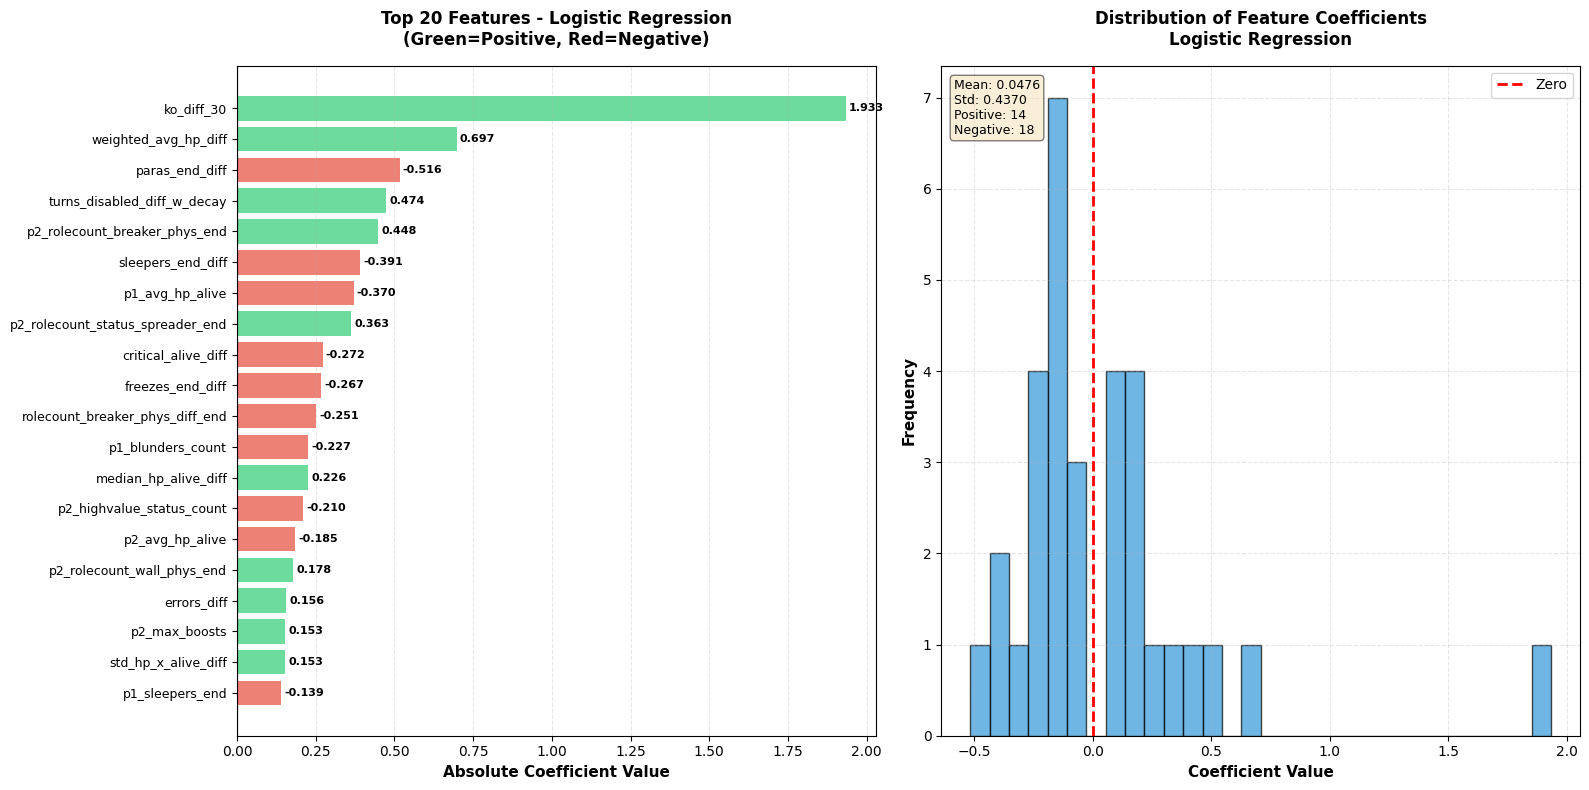


 Logistic Regression plot saved: logistic_feature_importance.png

 Analyzing XGBoost Feature Importance...

 Top 15 Features for XGBoost:
                         feature  importance
     turns_disabled_diff_w_decay    0.149283
                      ko_diff_30    0.064305
             turns_disabled_diff    0.064290
         statused_alive_end_diff    0.046682
           p2_statused_alive_end    0.037460
                 p2_avg_hp_alive    0.027148
   p2_rolecount_breaker_phys_end    0.026072
               p2_critical_alive    0.025883
            median_hp_alive_diff    0.022545
                freezes_end_diff    0.020277
               sleepers_end_diff    0.018531
             critical_alive_diff    0.015096
p2_rolecount_status_spreader_end    0.014267
            weighted_avg_hp_diff    0.014245
           p1_statused_alive_end    0.014168


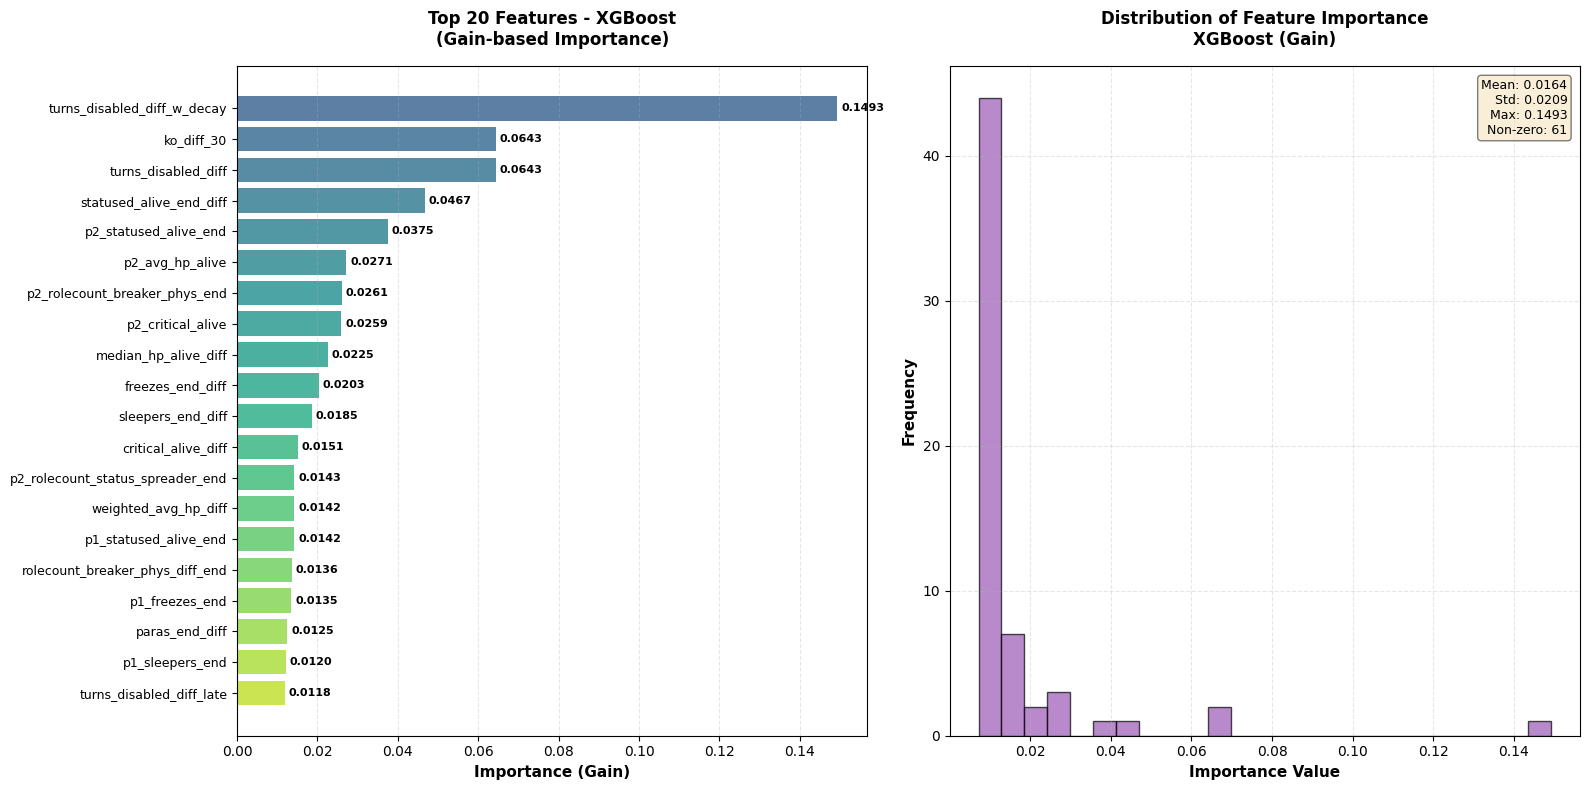


 XGBoost plot saved: xgboost_feature_importance.png

 Comparative Feature Importance Analysis...

 Features with most similar rankings (Top 10):
                         feature  log_rank  abs_coefficient  xgb_rank  importance  rank_diff
                freezes_end_diff         9         0.266847         9    0.020277          0
                      ko_diff_30         0         1.932854         1    0.064305          1
                 p1_sleepers_end        19         0.138948        18    0.012041          1
   p2_rolecount_breaker_phys_end         4         0.448399         6    0.026072          2
     turns_disabled_diff_w_decay         3         0.473535         0    0.149283          3
             critical_alive_diff         8         0.271905        11    0.015096          3
             std_hp_x_alive_diff        18         0.152773        21    0.011448          3
            median_hp_alive_diff        12         0.226462         8    0.022545          4
               sl

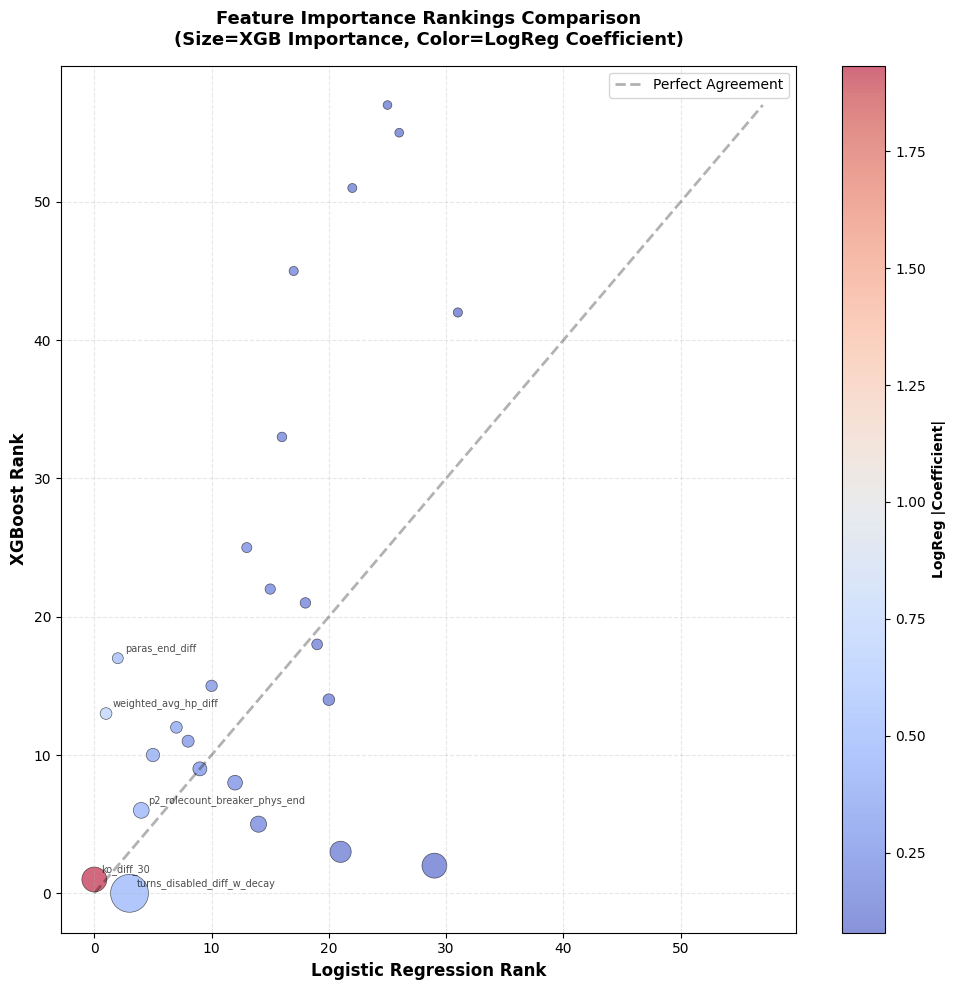


 Comparison plot saved: feature_importance_comparison.png
FEATURE IMPORTANCE ANALYSIS COMPLETE


In [28]:
# FEATURE IMPORTANCE ANALYSIS


print("FEATURE IMPORTANCE ANALYSIS")


# 1. LOGISTIC REGRESSION FEATURE IMPORTANCE


print("\n Analyzing Logistic Regression Feature Importance...")

# Train final LogReg model on full dataset
log_final_scaler = StandardScaler()
X_train_log_scaled = log_final_scaler.fit_transform(X_train_log)

log_final = LogisticRegression(
    penalty='l2',
    C=0.1,
    solver='saga',
    random_state=SEED, 
    max_iter=5000
)
log_final.fit(X_train_log_scaled, y_train)

# Extract coefficients
log_importance_df = pd.DataFrame({
    'feature': log_features,
    'coefficient': log_final.coef_[0],
    'abs_coefficient': np.abs(log_final.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print(f"\n Top 15 Features for Logistic Regression:")
print(log_importance_df.head(15).to_string(index=False))

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Top 20 features by absolute coefficient
top_n = 20
top_features = log_importance_df.head(top_n)

colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in top_features['coefficient']]
ax1.barh(range(top_n), top_features['abs_coefficient'], color=colors, alpha=0.7)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_features['feature'], fontsize=9)
ax1.invert_yaxis()
ax1.set_xlabel('Absolute Coefficient Value', fontsize=11, fontweight='bold')
ax1.set_title(f'Top {top_n} Features - Logistic Regression\n(Green=Positive, Red=Negative)', 
              fontsize=12, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.axvline(x=0, color='black', linewidth=0.8)

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax1.text(row['abs_coefficient'] + 0.01, i, f"{row['coefficient']:.3f}", 
             va='center', fontsize=8, fontweight='bold')

# Plot 2: Coefficient distribution
ax2.hist(log_importance_df['coefficient'], bins=30, color='#3498db', 
         alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
ax2.set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Distribution of Feature Coefficients\nLogistic Regression', 
              fontsize=12, fontweight='bold', pad=15)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3, linestyle='--')

# Add statistics box
stats_text = f"Mean: {log_importance_df['coefficient'].mean():.4f}\n"
stats_text += f"Std: {log_importance_df['coefficient'].std():.4f}\n"
stats_text += f"Positive: {(log_importance_df['coefficient'] > 0).sum()}\n"
stats_text += f"Negative: {(log_importance_df['coefficient'] < 0).sum()}"
ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, 
         fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', 
         facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('logistic_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Logistic Regression plot saved: logistic_feature_importance.png")



# 2. XGBOOST FEATURE IMPORTANCE


print("\n Analyzing XGBoost Feature Importance...")

# Train final XGB model on full dataset
xgb_final = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED, 
    eval_metric='logloss'
)
xgb_final.fit(X_train_xgb, y_train)

# Extract feature importance (gain-based)
xgb_importance_df = pd.DataFrame({
    'feature': xgb_features,
    'importance': xgb_final.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n Top 15 Features for XGBoost:")
print(xgb_importance_df.head(15).to_string(index=False))

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Top 20 features by importance
top_n = 20
top_features_xgb = xgb_importance_df.head(top_n)

colors_xgb = plt.cm.viridis(np.linspace(0.3, 0.9, top_n))
ax1.barh(range(top_n), top_features_xgb['importance'], color=colors_xgb, alpha=0.8)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_features_xgb['feature'], fontsize=9)
ax1.invert_yaxis()
ax1.set_xlabel('Importance (Gain)', fontsize=11, fontweight='bold')
ax1.set_title(f'Top {top_n} Features - XGBoost\n(Gain-based Importance)', 
              fontsize=12, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (idx, row) in enumerate(top_features_xgb.iterrows()):
    ax1.text(row['importance'] + 0.001, i, f"{row['importance']:.4f}", 
             va='center', fontsize=8, fontweight='bold')

# Plot 2: Importance distribution
ax2.hist(xgb_importance_df['importance'], bins=25, color='#9b59b6', 
         alpha=0.7, edgecolor='black')
ax2.set_xlabel('Importance Value', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Distribution of Feature Importance\nXGBoost (Gain)', 
              fontsize=12, fontweight='bold', pad=15)
ax2.grid(alpha=0.3, linestyle='--')

# Add statistics box
stats_text_xgb = f"Mean: {xgb_importance_df['importance'].mean():.4f}\n"
stats_text_xgb += f"Std: {xgb_importance_df['importance'].std():.4f}\n"
stats_text_xgb += f"Max: {xgb_importance_df['importance'].max():.4f}\n"
stats_text_xgb += f"Non-zero: {(xgb_importance_df['importance'] > 0).sum()}"
ax2.text(0.98, 0.98, stats_text_xgb, transform=ax2.transAxes, 
         fontsize=9, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n XGBoost plot saved: xgboost_feature_importance.png")



# 3. COMPARATIVE ANALYSIS


print("\n Comparative Feature Importance Analysis...")

# Find common features and compare rankings
common_features = set(log_features) & set(xgb_features)

if common_features:
    log_rank = log_importance_df.reset_index(drop=True).reset_index()
    log_rank.columns = ['log_rank', 'feature', 'coefficient', 'abs_coefficient']
    
    xgb_rank = xgb_importance_df.reset_index(drop=True).reset_index()
    xgb_rank.columns = ['xgb_rank', 'feature', 'importance']
    
    comparison_df = pd.merge(
        log_rank[log_rank['feature'].isin(common_features)][['feature', 'log_rank', 'abs_coefficient']],
        xgb_rank[xgb_rank['feature'].isin(common_features)][['feature', 'xgb_rank', 'importance']],
        on='feature'
    )
    
    comparison_df['rank_diff'] = abs(comparison_df['log_rank'] - comparison_df['xgb_rank'])
    comparison_df = comparison_df.sort_values('rank_diff')
    
    print(f"\n Features with most similar rankings (Top 10):")
    print(comparison_df.head(10).to_string(index=False))
    
    print(f"\n Features with most different rankings (Top 10):")
    print(comparison_df.tail(10).to_string(index=False))
    
    # Create comparison scatter plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    scatter = ax.scatter(comparison_df['log_rank'], 
                        comparison_df['xgb_rank'],
                        c=comparison_df['abs_coefficient'],
                        s=comparison_df['importance']*5000,
                        alpha=0.6,
                        cmap='coolwarm',
                        edgecolors='black',
                        linewidth=0.5)
    
    # Add diagonal line (perfect agreement)
    max_rank = max(comparison_df['log_rank'].max(), comparison_df['xgb_rank'].max())
    ax.plot([0, max_rank], [0, max_rank], 'k--', alpha=0.3, linewidth=2, label='Perfect Agreement')
    
    ax.set_xlabel('Logistic Regression Rank', fontsize=12, fontweight='bold')
    ax.set_ylabel('XGBoost Rank', fontsize=12, fontweight='bold')
    ax.set_title('Feature Importance Rankings Comparison\n(Size=XGB Importance, Color=LogReg Coefficient)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('LogReg |Coefficient|', fontsize=10, fontweight='bold')
    
    # Annotate top 5 most important features from each model
    top_log = comparison_df.nsmallest(5, 'log_rank')
    top_xgb = comparison_df.nsmallest(5, 'xgb_rank')
    
    for _, row in top_log.iterrows():
        ax.annotate(row['feature'], 
                   (row['log_rank'], row['xgb_rank']),
                   fontsize=7, alpha=0.7, 
                   xytext=(5, 5), textcoords='offset points')
    
    plt.tight_layout()
    plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n Comparison plot saved: feature_importance_comparison.png")

print("FEATURE IMPORTANCE ANALYSIS COMPLETE")


In [29]:
# GRID SEARCH & HYPERPARAMETER OPTIMIZATION (LOG + XGB)
# We optimize hyperparameters for both models using exhaustive GridSearchCV with 5-fold stratified cross-validation. For Logistic Regression,
# we search penalty types (L1/L2/Elasticnet), regularization strength (C), and class weights. For XGBoost, we tune tree depth, learning rate,
# number of estimators, and regularization parameters. 

print("GRID SEARCH & HYPERPARAMETER OPTIMIZATION")


cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)


# 1. Logistic Regression

print("\n Optimizing Logistic Regression...")
log_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='saga', random_state=SEED, max_iter=5000))
])

log_param_grid = {
    'clf__penalty': ['l1', 'l2','elasticnet'],
    'clf__C': [0.01, 0.1, 0.5, 1.0, 2.0],
    'clf__class_weight': [None, 'balanced']
}

log_grid = GridSearchCV(
    log_pipeline,
    log_param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
log_grid.fit(X_train_log, y_train)

print(f"\n   Best params: {log_grid.best_params_}")
print(f"   Best CV score: {log_grid.best_score_:.4f}")


# 2. XGBoost

print("\n Optimizing XGBoost...")
xgb_param_grid = {
    'n_estimators': [700, 900],
    'max_depth': [2, 3],
    'learning_rate': [0.03, 0.04],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.6, 0.7],
    'min_child_weight': [60, 75],
    'gamma': [0.5],
    'reg_lambda': [5],
    'reg_alpha': [0.4]
}

xgb_grid = GridSearchCV(
    XGBClassifier(random_state=SEED, eval_metric='logloss', tree_method='hist'),
    xgb_param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train_xgb, y_train)

print(f"\n   Best params: {xgb_grid.best_params_}")
print(f"   Best CV score: {xgb_grid.best_score_:.4f}")






GRID SEARCH & HYPERPARAMETER OPTIMIZATION

 Optimizing Logistic Regression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

   Best params: {'clf__C': 0.01, 'clf__class_weight': None, 'clf__penalty': 'l2'}
   Best CV score: 0.8458

 Optimizing XGBoost...
Fitting 5 folds for each of 64 candidates, totalling 320 fits

   Best params: {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.04, 'max_depth': 3, 'min_child_weight': 60, 'n_estimators': 900, 'reg_alpha': 0.4, 'reg_lambda': 5, 'subsample': 0.7}
   Best CV score: 0.8472


In [30]:
# CROSS-VALIDATION WITH BEST MODELS (LOG + XGB)
# We perform 10-fold stratified cross-validation using the optimized hyperparameters from grid search. For each fold, we train both models
# on 9 folds and predict on the holdout fold, collecting out-of-fold predictions for ensemble blending. This produces reliable performance
# estimates and test predictions averaged across 10 models per type. 

print("CROSS-VALIDATION WITH OPTIMIZED MODELS")


NFOLDS = 10
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

oof_log = np.zeros(len(X_train_log))
oof_xgb = np.zeros(len(X_train_xgb))


test_pred_log = np.zeros(len(X_test_log))
test_pred_xgb = np.zeros(len(X_test_xgb))


fold_results = []

for fold, (tr_idx, va_idx) in enumerate(kfold.split(X_train_log, y_train), 1):
    # Logistic
    X_tr_log, X_va_log = X_train_log.iloc[tr_idx], X_train_log.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    
    log_fold = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(**{k.replace('clf__', ''): v 
                                      for k, v in log_grid.best_params_.items()},
                                   random_state=SEED, max_iter=5000, solver='saga'))
    ])
    log_fold.fit(X_tr_log, y_tr)
    oof_log[va_idx] = log_fold.predict_proba(X_va_log)[:, 1]
    test_pred_log += log_fold.predict_proba(X_test_log)[:, 1] / NFOLDS
    
    # XGBoost
    X_tr_xgb, X_va_xgb = X_train_xgb.iloc[tr_idx], X_train_xgb.iloc[va_idx]
    
    xgb_fold = XGBClassifier(**xgb_grid.best_params_, random_state=SEED, eval_metric='logloss')
    xgb_fold.fit(X_tr_xgb, y_tr)
    oof_xgb[va_idx] = xgb_fold.predict_proba(X_va_xgb)[:, 1]
    test_pred_xgb += xgb_fold.predict_proba(X_test_xgb)[:, 1] / NFOLDS
    
    
    
    # Metrics
    acc_log = accuracy_score(y_va, (oof_log[va_idx] >= 0.5).astype(int))
    acc_xgb = accuracy_score(y_va, (oof_xgb[va_idx] >= 0.5).astype(int))
   
    
    ll_log = log_loss(y_va, oof_log[va_idx])
    ll_xgb = log_loss(y_va, oof_xgb[va_idx])
   
    
    fold_results.append({
        'fold': fold,
        'log_acc': acc_log,
        'xgb_acc': acc_xgb,
        'log_ll': ll_log,
        'xgb_ll': ll_xgb,
       
    })
    
    print(f"\n[FOLD {fold}]")
    print(f"   LOG: ACC={acc_log:.4f}, LogLoss={ll_log:.4f}")
    print(f"   XGB: ACC={acc_xgb:.4f}, LogLoss={ll_xgb:.4f}")
   

# Overall OOF metrics


print("OVERALL OUT-OF-FOLD METRICS")

acc_log = accuracy_score(y_train, (oof_log >= 0.5).astype(int))
ll_log = log_loss(y_train, oof_log)
print(f"\n[OOF] LOG   ACC={acc_log:.4f}  LOGLOSS={ll_log:.4f}")

acc_xgb = accuracy_score(y_train, (oof_xgb >= 0.5).astype(int))
ll_xgb = log_loss(y_train, oof_xgb)
print(f"[OOF] XGB   ACC={acc_xgb:.4f}  LOGLOSS={ll_xgb:.4f}")


CROSS-VALIDATION WITH OPTIMIZED MODELS

[FOLD 1]
   LOG: ACC=0.8420, LogLoss=0.3649
   XGB: ACC=0.8450, LogLoss=0.3693

[FOLD 2]
   LOG: ACC=0.8500, LogLoss=0.3610
   XGB: ACC=0.8440, LogLoss=0.3575

[FOLD 3]
   LOG: ACC=0.8450, LogLoss=0.3800
   XGB: ACC=0.8280, LogLoss=0.3792

[FOLD 4]
   LOG: ACC=0.8590, LogLoss=0.3450
   XGB: ACC=0.8600, LogLoss=0.3384

[FOLD 5]
   LOG: ACC=0.8280, LogLoss=0.3954
   XGB: ACC=0.8310, LogLoss=0.3939

[FOLD 6]
   LOG: ACC=0.8560, LogLoss=0.3484
   XGB: ACC=0.8560, LogLoss=0.3489

[FOLD 7]
   LOG: ACC=0.8320, LogLoss=0.3685
   XGB: ACC=0.8450, LogLoss=0.3571

[FOLD 8]
   LOG: ACC=0.8530, LogLoss=0.3656
   XGB: ACC=0.8460, LogLoss=0.3654

[FOLD 9]
   LOG: ACC=0.8320, LogLoss=0.4004
   XGB: ACC=0.8280, LogLoss=0.4042

[FOLD 10]
   LOG: ACC=0.8569, LogLoss=0.3551
   XGB: ACC=0.8549, LogLoss=0.3559
OVERALL OUT-OF-FOLD METRICS

[OOF] LOG   ACC=0.8454  LOGLOSS=0.3684
[OOF] XGB   ACC=0.8438  LOGLOSS=0.3670


In [31]:
# ENSEMBLE WEIGHT OPTIMIZATION (LOG + XGB)
# We search for optimal blending weights between LogisticRegression and XGBoost predictions by testing alpha values from 0.20 to 0.80 in 0.02
# increments. For each alpha, we compute ensemble predictions as alpha × LogReg + (1-alpha) × XGBoost and evaluate OOF accuracy. 

print("ENSEMBLE WEIGHT OPTIMIZATION")


best_alpha = 0.6
best_score = 0.0

print("\nSearching for optimal blend weight...")
for alpha in np.arange(0.2, 0.8, 0.02):
    oof_blend = alpha * oof_log + (1 - alpha) * oof_xgb
    preds = (oof_blend >= 0.5).astype(int)
    score = accuracy_score(y_train, preds)
    
    if score > best_score:
        best_score = score
        best_alpha = alpha
        print(f"    New best: Alpha={alpha:.2f}, Accuracy={score:.4f}")

BLEND_W_LOG = best_alpha
BLEND_W_XGB = 1 - best_alpha

oof_blend = BLEND_W_LOG * oof_log + BLEND_W_XGB * oof_xgb
test_pred = BLEND_W_LOG * test_pred_log + BLEND_W_XGB * test_pred_xgb

acc_b = accuracy_score(y_train, (oof_blend >= 0.5).astype(int))
ll_b = log_loss(y_train, oof_blend)


print(f"FINAL ENSEMBLE: LOG={BLEND_W_LOG:.2f}, XGB={BLEND_W_XGB:.2f}")
print(f"[OOF] ENS   ACC={acc_b:.4f}  LOGLOSS={ll_b:.4f}")


ENSEMBLE WEIGHT OPTIMIZATION

Searching for optimal blend weight...
    New best: Alpha=0.20, Accuracy=0.8460
    New best: Alpha=0.22, Accuracy=0.8462
    New best: Alpha=0.24, Accuracy=0.8468
    New best: Alpha=0.26, Accuracy=0.8469
    New best: Alpha=0.50, Accuracy=0.8470
    New best: Alpha=0.54, Accuracy=0.8475
FINAL ENSEMBLE: LOG=0.54, XGB=0.46
[OOF] ENS   ACC=0.8475  LOGLOSS=0.3627


In [32]:
# STACKING ENSEMBLE (META-LEARNING)



print("STACKING ENSEMBLE")


# Step 1:
X_meta_train = np.column_stack([oof_log, oof_xgb, ])

print(f"Meta-features shape: {X_meta_train.shape}")
print(f"  - oof_log: mean={oof_log.mean():.3f}, std={oof_log.std():.3f}")
print(f"  - oof_xgb: mean={oof_xgb.mean():.3f}, std={oof_xgb.std():.3f}")

# Step 2: Train meta-model on OOF predictions
meta_model = LogisticRegression(C=1.0, random_state=SEED, max_iter=1000)
meta_model.fit(X_meta_train, y_train)

print(f"\nMeta-model learned weights (coefficients):")
print(f"  LogReg coefficient: {meta_model.coef_[0][0]:+.4f}")
print(f"  XGBoost coefficient: {meta_model.coef_[0][1]:+.4f}")
print(f"  Intercept: {meta_model.intercept_[0]:+.4f}")

# Step 3: 
meta_pred_train = meta_model.predict_proba(X_meta_train)[:, 1]

acc_meta = accuracy_score(y_train, (meta_pred_train >= 0.5).astype(int))
ll_meta = log_loss(y_train, meta_pred_train)

print(f"\n[TRAIN] STACKING  ACC={acc_meta:.4f}  LOGLOSS={ll_meta:.4f}")

# Step 4: Test predictions 
X_meta_test = np.column_stack([test_pred_log, test_pred_xgb])
test_pred_stack = meta_model.predict_proba(X_meta_test)[:, 1]

# Step 5: Meta Model vs Weighted Average
print("COMPARISON: Weighted Average vs Stacking")
print(f"  Weighted Average: ACC={acc_b:.4f}, LogLoss={ll_b:.4f}")
print(f"  Stacking:         ACC={acc_meta:.4f}, LogLoss={ll_meta:.4f}")
print(f"  Improvement:      {acc_meta - acc_b:+.4f} accuracy")

if acc_meta > acc_b:
    print(f"\n Stacking is better! Use this for final submission.")
    final_test_pred = test_pred_stack
else:
    print(f"\n  Weighted average is better.")
    final_test_pred = test_pred




STACKING ENSEMBLE
Meta-features shape: (9999, 2)
  - oof_log: mean=0.500, std=0.350
  - oof_xgb: mean=0.500, std=0.371

Meta-model learned weights (coefficients):
  LogReg coefficient: +3.5715
  XGBoost coefficient: +2.5033
  Intercept: -3.0162

[TRAIN] STACKING  ACC=0.8467  LOGLOSS=0.3675
COMPARISON: Weighted Average vs Stacking
  Weighted Average: ACC=0.8475, LogLoss=0.3627
  Stacking:         ACC=0.8467, LogLoss=0.3675
  Improvement:      -0.0008 accuracy

  Weighted average is better.


In [33]:
# LEARNING CURVES & OVERFITTING ANALYSIS
# We generate learning curves for both models to diagnose overfitting by training on progressively larger subsets and measuring training
# vs validation accuracy. We plot these curves with standard deviation shading and calculate train-val gaps at full data size. 


print("LEARNING CURVES - OVERFITTING ANALYSIS")


def plot_learning_curves(estimator, X, y, title, cv=5):
    "Plot learning curves to detect overfitting"
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator, X, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        random_state=SEED
    )
    
    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes_abs, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes_abs, val_mean, 'o-', color='g', label='Validation score')
    
    # Shade std deviation
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='r')
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='g')
    
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curves - {title}')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Gap analysis
    final_gap = train_mean[-1] - val_mean[-1]
    print(f"\n {title}")
    print(f"   Final Training Accuracy: {train_mean[-1]:.4f}")
    print(f"   Final Validation Accuracy: {val_mean[-1]:.4f}")
    print(f"   Train-Val Gap: {final_gap:.4f}")
    
    if final_gap > 0.05:
        print(f"   WARNING: Possible overfitting detected!")
    elif final_gap < 0.01:
        print(f"   Good generalization")
    else:
        print(f"   Acceptable gap")
    
    return train_mean[-1], val_mean[-1], final_gap

# 1. Logistic Regression Learning Curve
log_estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(**{k.replace('clf__', ''): v 
                                  for k, v in log_grid.best_params_.items()},
                               random_state=SEED, max_iter=5000, solver='saga'))
])
log_train_acc, log_val_acc, log_gap = plot_learning_curves(
    log_estimator, X_train, y_train, 
    "Logistic Regression", cv=5
)
plt.savefig('learning_curve_logistic.png', dpi=150, bbox_inches='tight')
plt.close()

# 2. XGBoost Learning Curve
xgb_estimator = XGBClassifier(**xgb_grid.best_params_, 
                              random_state=SEED, 
                              eval_metric='logloss')
xgb_train_acc, xgb_val_acc, xgb_gap = plot_learning_curves(
    xgb_estimator, X_train, y_train,
    "XGBoost", cv=5
)
plt.savefig('learning_curve_xgboost.png', dpi=150, bbox_inches='tight')
plt.close()



# Summary comparison
print("OVERFITTING SUMMARY")

comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'Train Acc': [log_train_acc, xgb_train_acc ],
    'Val Acc': [log_val_acc, xgb_val_acc ],
    'Gap': [log_gap, xgb_gap ],
    'Status': [
        'Overfitting' if log_gap > 0.05 else ' OK',
        'Overfitting' if xgb_gap > 0.05 else ' OK'
    ]
})

print("\n" + comparison.to_string(index=False))
print("\n Learning curves saved:")
print("   - learning_curve_logistic.png")
print("   - learning_curve_xgboost.png")


LEARNING CURVES - OVERFITTING ANALYSIS

 Logistic Regression
   Final Training Accuracy: 0.8457
   Final Validation Accuracy: 0.8418
   Train-Val Gap: 0.0039
   Good generalization

 XGBoost
   Final Training Accuracy: 0.8733
   Final Validation Accuracy: 0.8428
   Train-Val Gap: 0.0305
   Acceptable gap
OVERFITTING SUMMARY

              Model  Train Acc  Val Acc      Gap Status
Logistic Regression   0.845656 0.841785 0.003871     OK
            XGBoost   0.873284 0.842785 0.030499     OK

 Learning curves saved:
   - learning_curve_logistic.png
   - learning_curve_xgboost.png


In [34]:
# CREATE SUBMISSION

#SUBMISSION FOR LOGISTIC MODEL
submission = pd.DataFrame({
    COL_ID: test_df[COL_ID],
    COL_TARGET: (test_pred_log >= 0.5).astype(int)
})

output_file = "submissionlog.csv"
submission.to_csv(output_file, index=False)
print(f"\n Submission saved: {output_file}")
print(f"   Shape: {submission.shape}")


#SUBMISSION FOR ENSAMBLE WEIGHTED MODEL
submission = pd.DataFrame({
    COL_ID: test_df[COL_ID],
    COL_TARGET: (test_pred >= 0.5).astype(int)
})

output_file = "submissionw.csv"
submission.to_csv(output_file, index=False)
print(f"\n Submission saved: {output_file}")
print(f"   Shape: {submission.shape}")


#SUBMISSION FOR META LEARNER MODEL
submission = pd.DataFrame({
    COL_ID: test_df[COL_ID],
    COL_TARGET: (test_pred_stack >= 0.5).astype(int)
})

output_file = "submissionfinal.csv"
submission.to_csv(output_file, index=False)

print(f"\n Submission saved: {output_file}")
print(f"   Shape: {submission.shape}")



 Submission saved: submissionlog.csv
   Shape: (5000, 2)

 Submission saved: submissionw.csv
   Shape: (5000, 2)

 Submission saved: submissionMETA.csv
   Shape: (5000, 2)
